In [154]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram

from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv


extRemes = importr("extRemes")

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [155]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [156]:
import warnings
warnings.filterwarnings('ignore')

In [157]:
from scipy.stats import genextreme as gev
def empirical_return_level(data):
    """
    Compute empirical return level using the algorithm introduced in Tutorial 2
    """
    df = pd.DataFrame(index=np.arange(data.size))
    # sort the data
    df["sorted"] = np.sort(data)[::-1]
    # rank via scipy instead to deal with duplicate values
    df["ranks_sp"] = np.sort(stats.rankdata(-data))
    # find exceedence probability
    n = data.size
    df["exceedance"] = df["ranks_sp"] / (n + 1)
    # find return period
    df["period"] = 1 / df["exceedance"]

    df = df[::-1]

    out = xr.DataArray(
        dims=["period"],
        coords={"period": df["period"]},
        data=df["sorted"],
        name="level",
    )
    return out

In [158]:
yearb=1941
yeare=2025

ifile='../AFI/ERA5_AFI_1941_2025.nc'

ds = xr.open_dataset(ifile)
ds = ds.sel(time=slice(f'{yearb}-01-01',f'{yeare}-02-01'))
ds = ds.sortby('lat')
ds['time'] = np.arange(yearb,yeare+1,1)

return_periods = [2, 5, 10, 25, 50, 100]
Tlon = ds.lon.data
Tlat = ds.lat.data

units = 'degree-days (°C)'

In [159]:
ptlon=[260,270,264.25,241,205,204,289]
ptlat=[48,40,37,46.25,68.75,60,45]

In [160]:
c=[1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000]
ksN=9999
year=np.arange(yearb,yeare,1)

# create vector of years
years = np.arange(1.1, 100, 0.1)

Text(0.5, 0.98, 'AFI mean (1941-2025)')

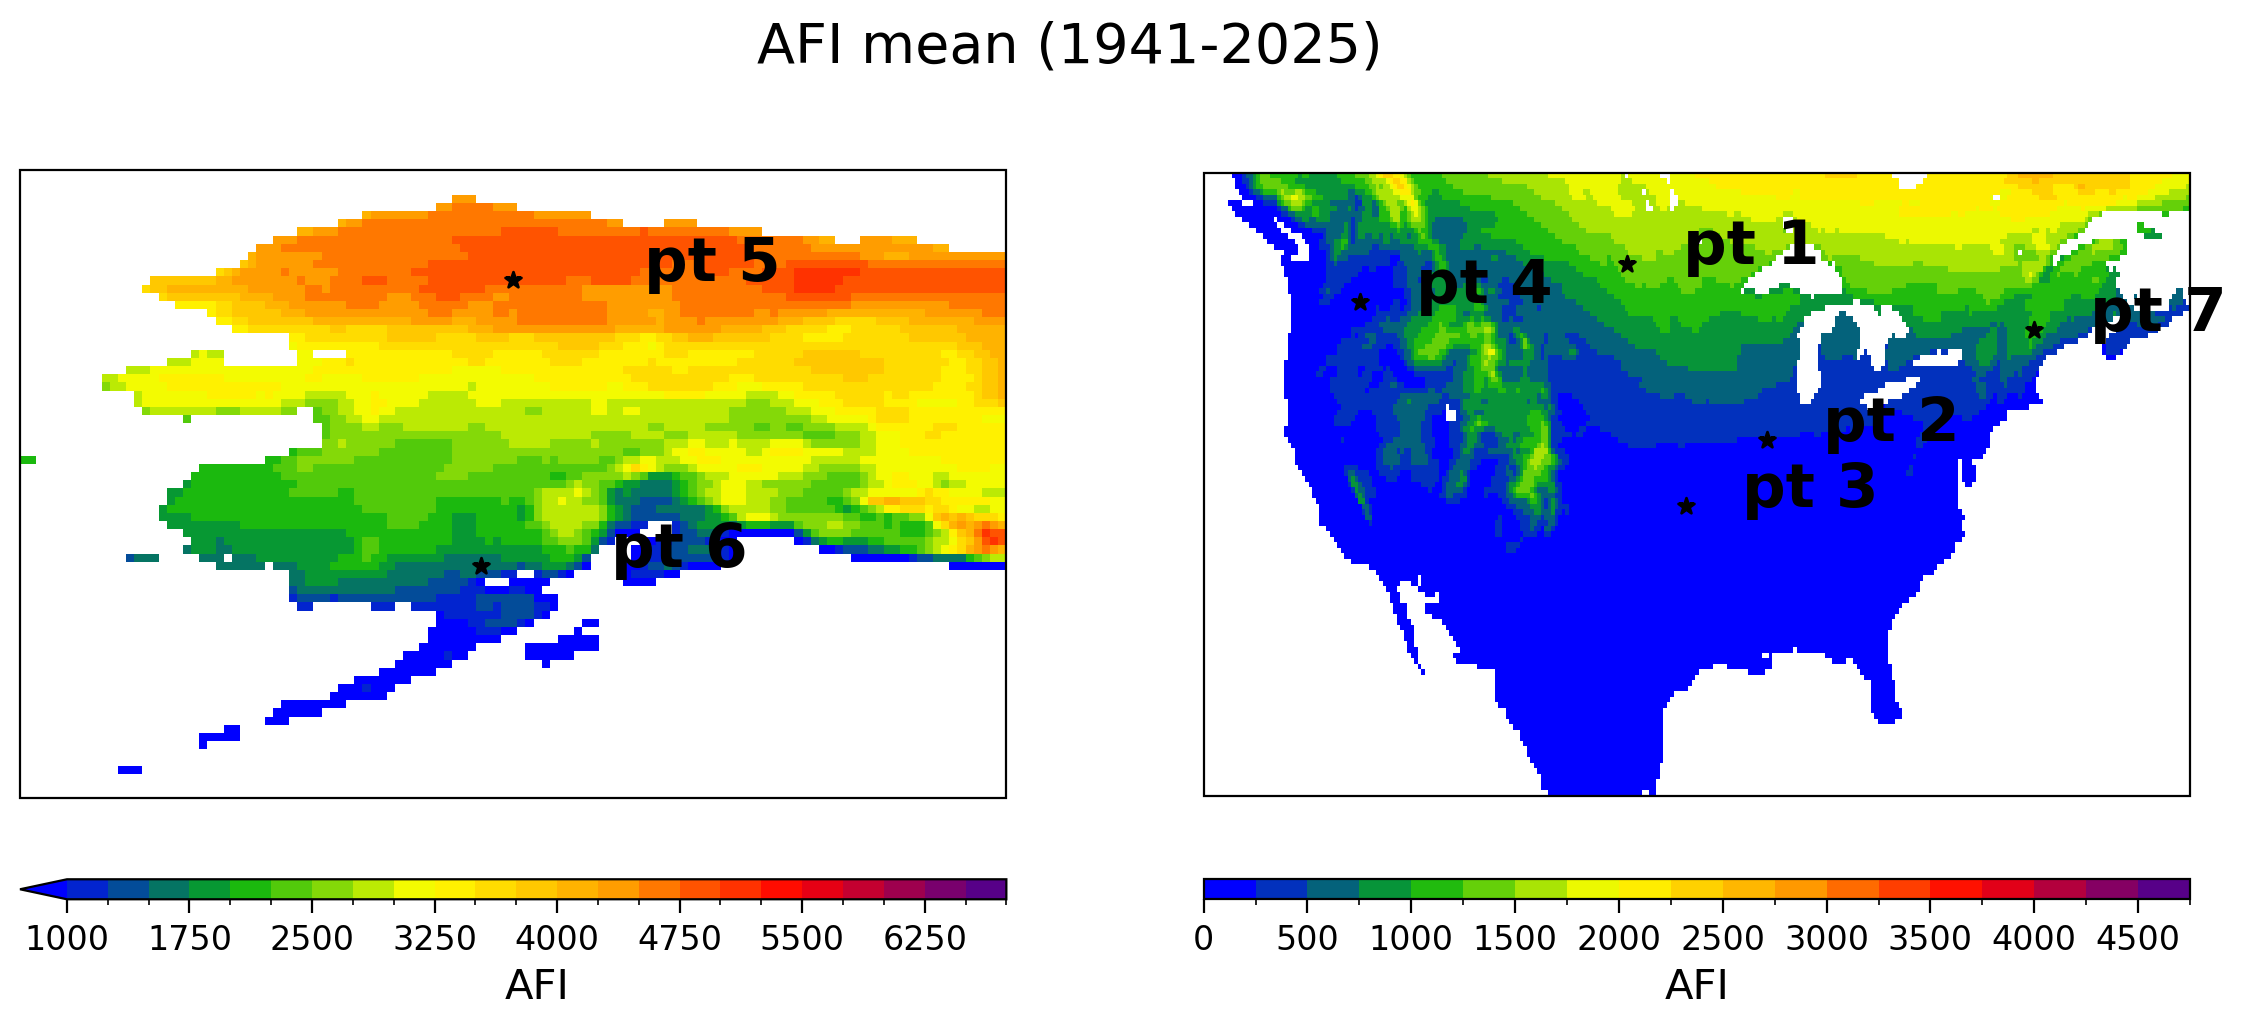

In [161]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(190,220),lat=slice(53,72)).plot(ax=ax[0],cmap=cmap,levels=np.arange(1000,7000,250),add_colorbar=False)
for ip in range(4,6):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[0].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label='AFI')
cbar.ax.tick_params(labelsize=12)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(230,300),lat=slice(22,52)).plot(ax=ax[1],cmap=cmap,levels=np.arange(0,5000,250),add_colorbar=False)
for ip in range(0,4):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[1].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
ax[1].scatter(ptlon[6],ptlat[6],marker='*',color='k')
ax[1].text(ptlon[6]-360+4,ptlat[6],f'pt {6+1}',color='k',size=22,weight='bold')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label='AFI')
cbar.ax.tick_params(labelsize=12)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)
plt.suptitle(f'AFI mean ({yearb}-{yeare})', fontsize=20)

In [162]:
CB_color = ['#377eb8', '#ff7f00', '#4daf4a',
            '#e41a1c', '#a65628', '#984ea3',
            '#999999', '#f781bf', '#dede00']

# Pt 1

In [163]:
ij=0
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

In [164]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI              year     
 Min.   : 627.6   Min.   :1941  
 1st Qu.:1105.0   1st Qu.:1962  
 Median :1367.3   Median :1983  
 Mean   :1342.6   Mean   :1983  
 3rd Qu.:1594.1   3rd Qu.:2004  
 Max.   :2098.6   Max.   :2025  



Define fit for GEV, Gumbel, Frechet, Weibull

#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  614.9226 


 Estimated parameters:
    location        scale        shape 
1229.8937803  344.9677043   -0.3302195 

 Standard Error Estimates:
  location      scale      shape 
41.2094390 29.6648976  0.0705145 

 Estimated parameter covariance matrix.
            location      scale        shape
location 1698.217866 -46.865494 -1.124964797
scale     -46.865494 880.006150 -1.286313102
shape      -1.124965  -1.286313  0.004972295

 AIC = 1235.845 

 BIC = 1243.173 


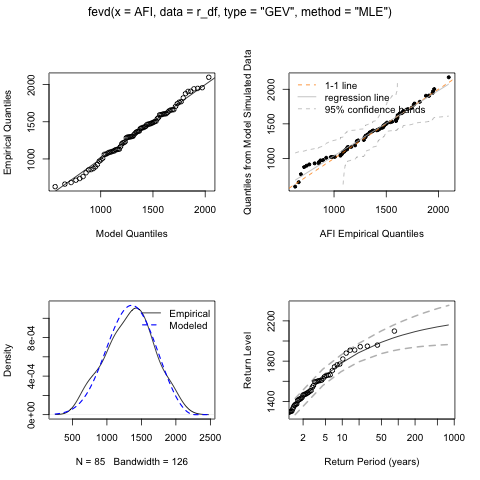

In [165]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  621.6822 


 Estimated parameters:
 location     scale 
1172.1901  328.4814 

 Standard Error Estimates:
location    scale 
37.80317 26.32418 

 Estimated parameter covariance matrix.
          location    scale
location 1429.0793 333.6369
scale     333.6369 692.9627

 AIC = 1247.364 

 BIC = 1252.25 


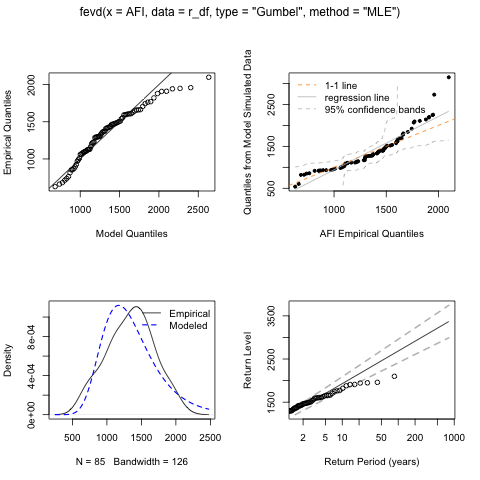

In [166]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

Extract return_periods

In [167]:
%R return_periods <- c( 1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
#%R rlWei<-return.level(fitWei, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

Example to show that
- stats.truncnorm needs to specify first guess to give a sensible result, didn't find an optimizer working.
- stats.genextreme : using optimize option or giving first guess give the same result
- stats.genextreme fc=0 (Gumbel): optimize option, giving first guess or nothing give the same result 

Text(0.5, 1.0, 'PT 1 (260$\\degree$E; 48$\\degree$N)')

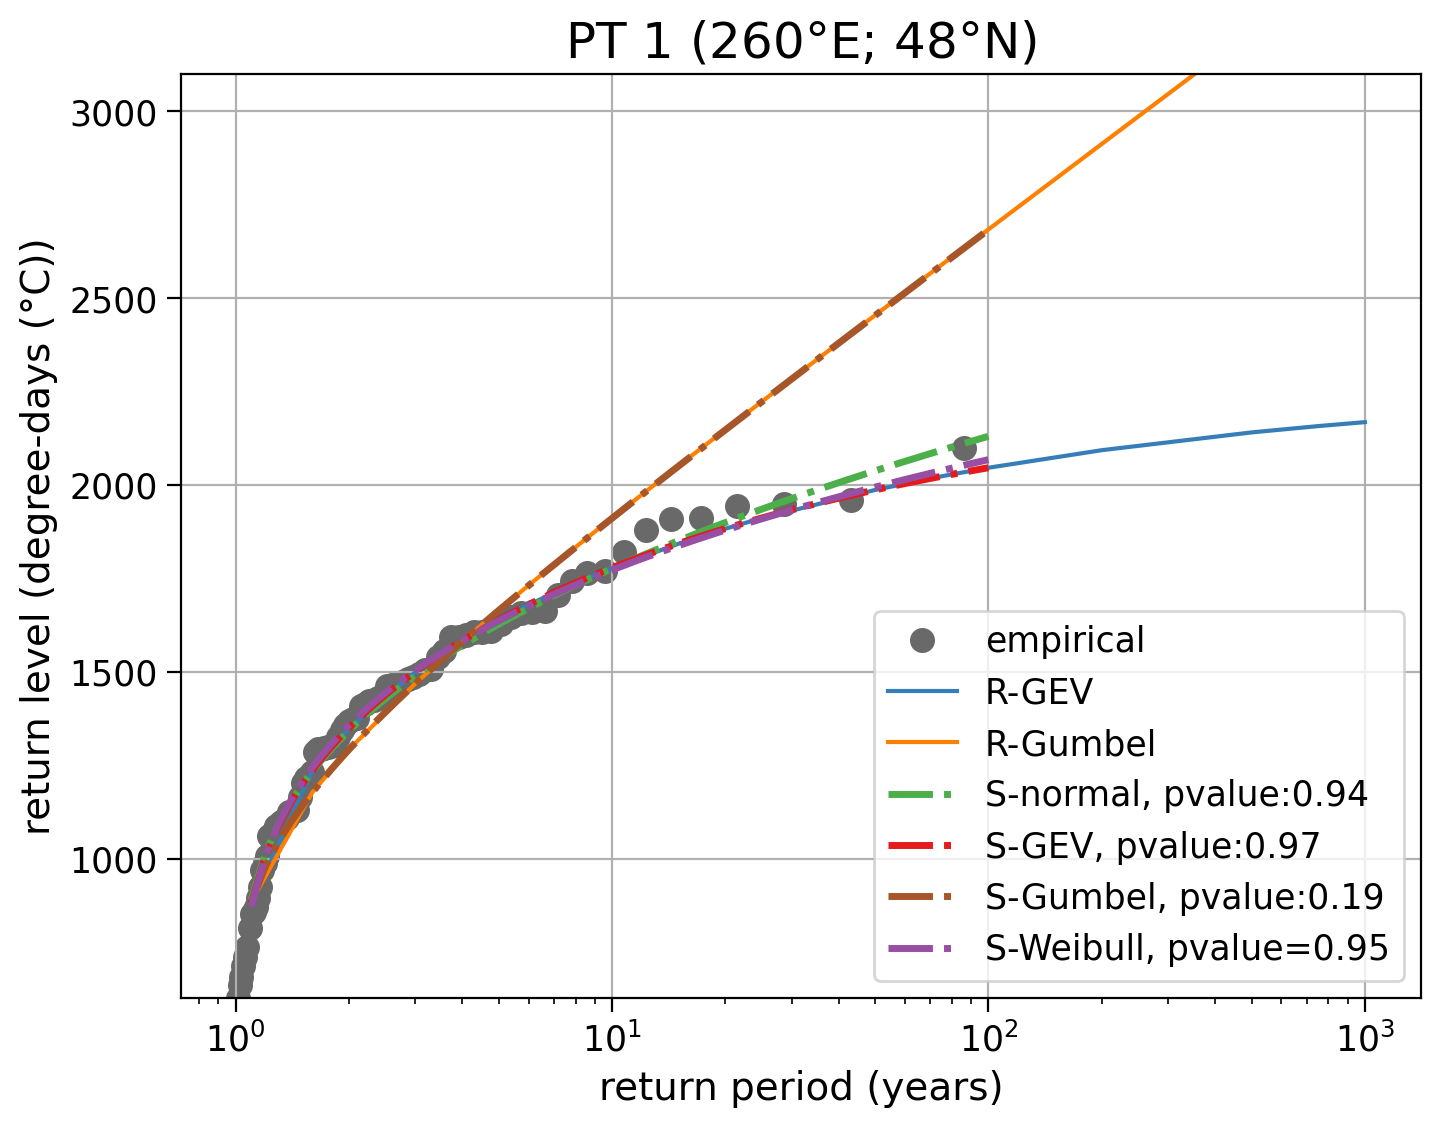

In [168]:

fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

In [169]:
nonzero_afis.min()

np.float64(627.576416015625)

For point1, R-GEV, S-GEV optimized and S-Gumbel give the same result.

Text(0.5, 1.0, 'PT 1 (260$\\degree$E;48$\\degree$N)')

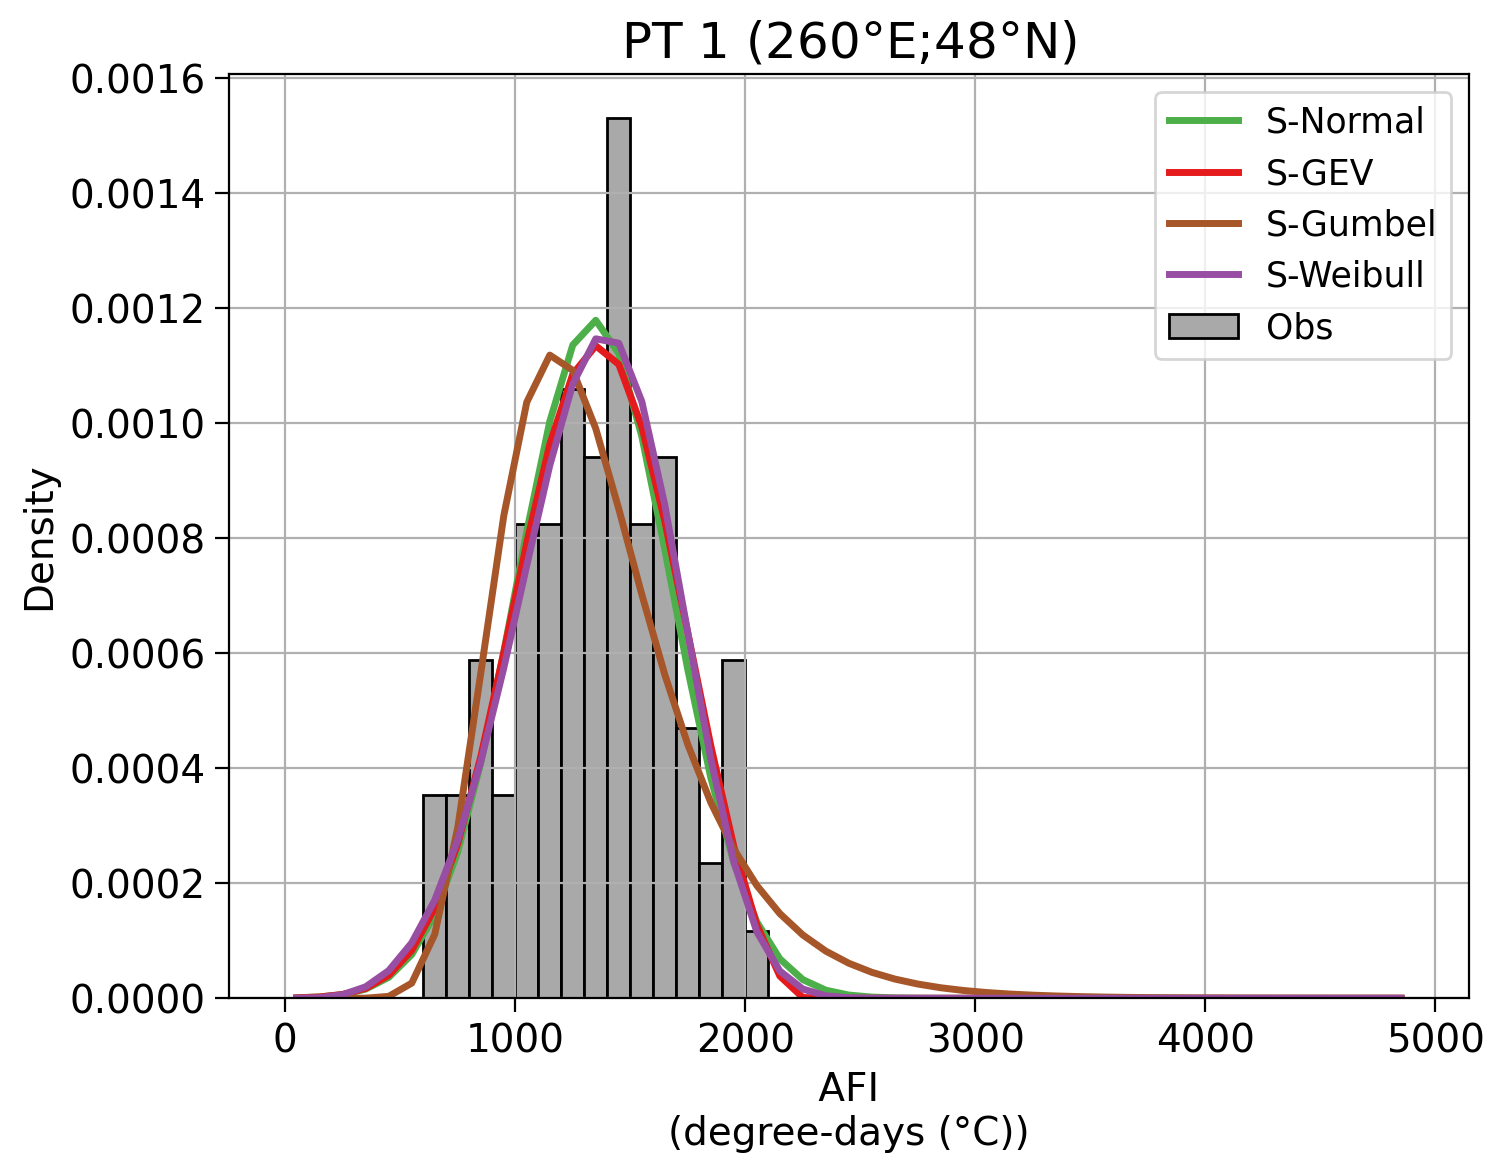

In [170]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

Only Scipy functions.

# Pt 2

In [171]:
ij=1
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

In [172]:
# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI              year     
 Min.   : 34.56   Min.   :1941  
 1st Qu.:154.19   1st Qu.:1962  
 Median :226.07   Median :1983  
 Mean   :237.89   Mean   :1983  
 3rd Qu.:303.31   3rd Qu.:2004  
 Max.   :657.32   Max.   :2025  



#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  527.3586 


 Estimated parameters:
   location       scale       shape 
180.9889591 103.9899397  -0.0315672 

 Standard Error Estimates:
   location       scale       shape 
12.74930555  9.20615653  0.08107685 

 Estimated parameter covariance matrix.
            location      scale        shape
location 162.5447920 42.1178576 -0.385099256
scale     42.1178576 84.7533180 -0.259218064
shape     -0.3850993 -0.2592181  0.006573455

 AIC = 1060.717 

 BIC = 1068.045 


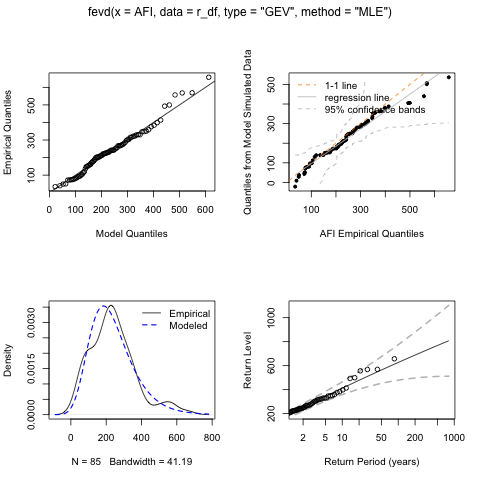

In [173]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  527.4294 


 Estimated parameters:
location    scale 
179.1315 102.8842 

 Standard Error Estimates:
 location     scale 
11.766053  8.690539 

 Estimated parameter covariance matrix.
          location    scale
location 138.44000 32.46158
scale     32.46158 75.52547

 AIC = 1058.859 

 BIC = 1063.744 


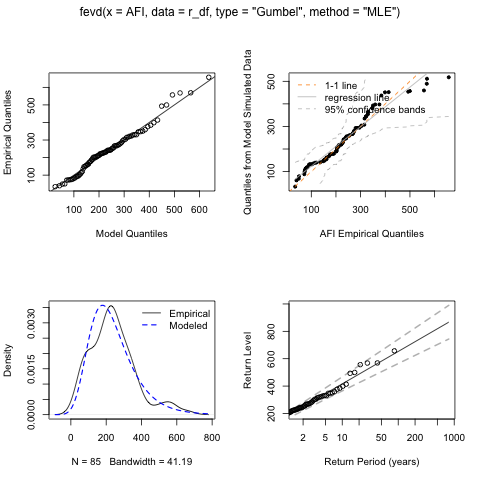

In [174]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [175]:
%R return_periods <- c( 1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb

Text(0.5, 1.0, 'PT 2 (270$\\degree$E; 40$\\degree$N)')

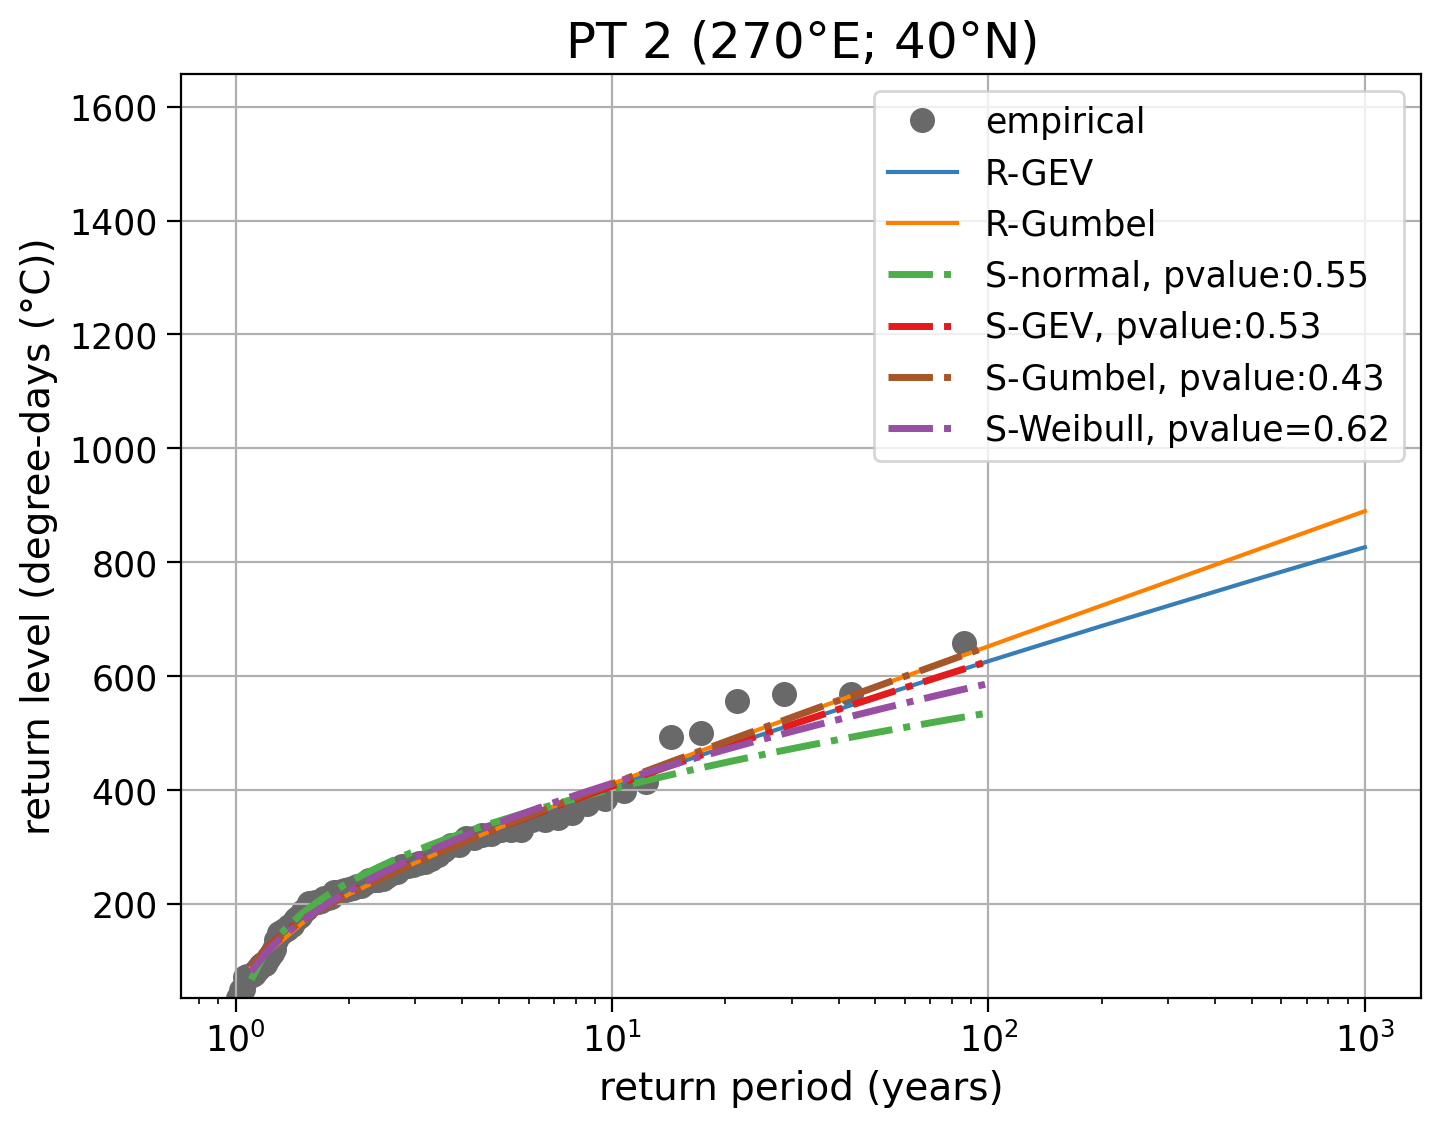

In [176]:
fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 2 (270$\\degree$E;40$\\degree$N)')

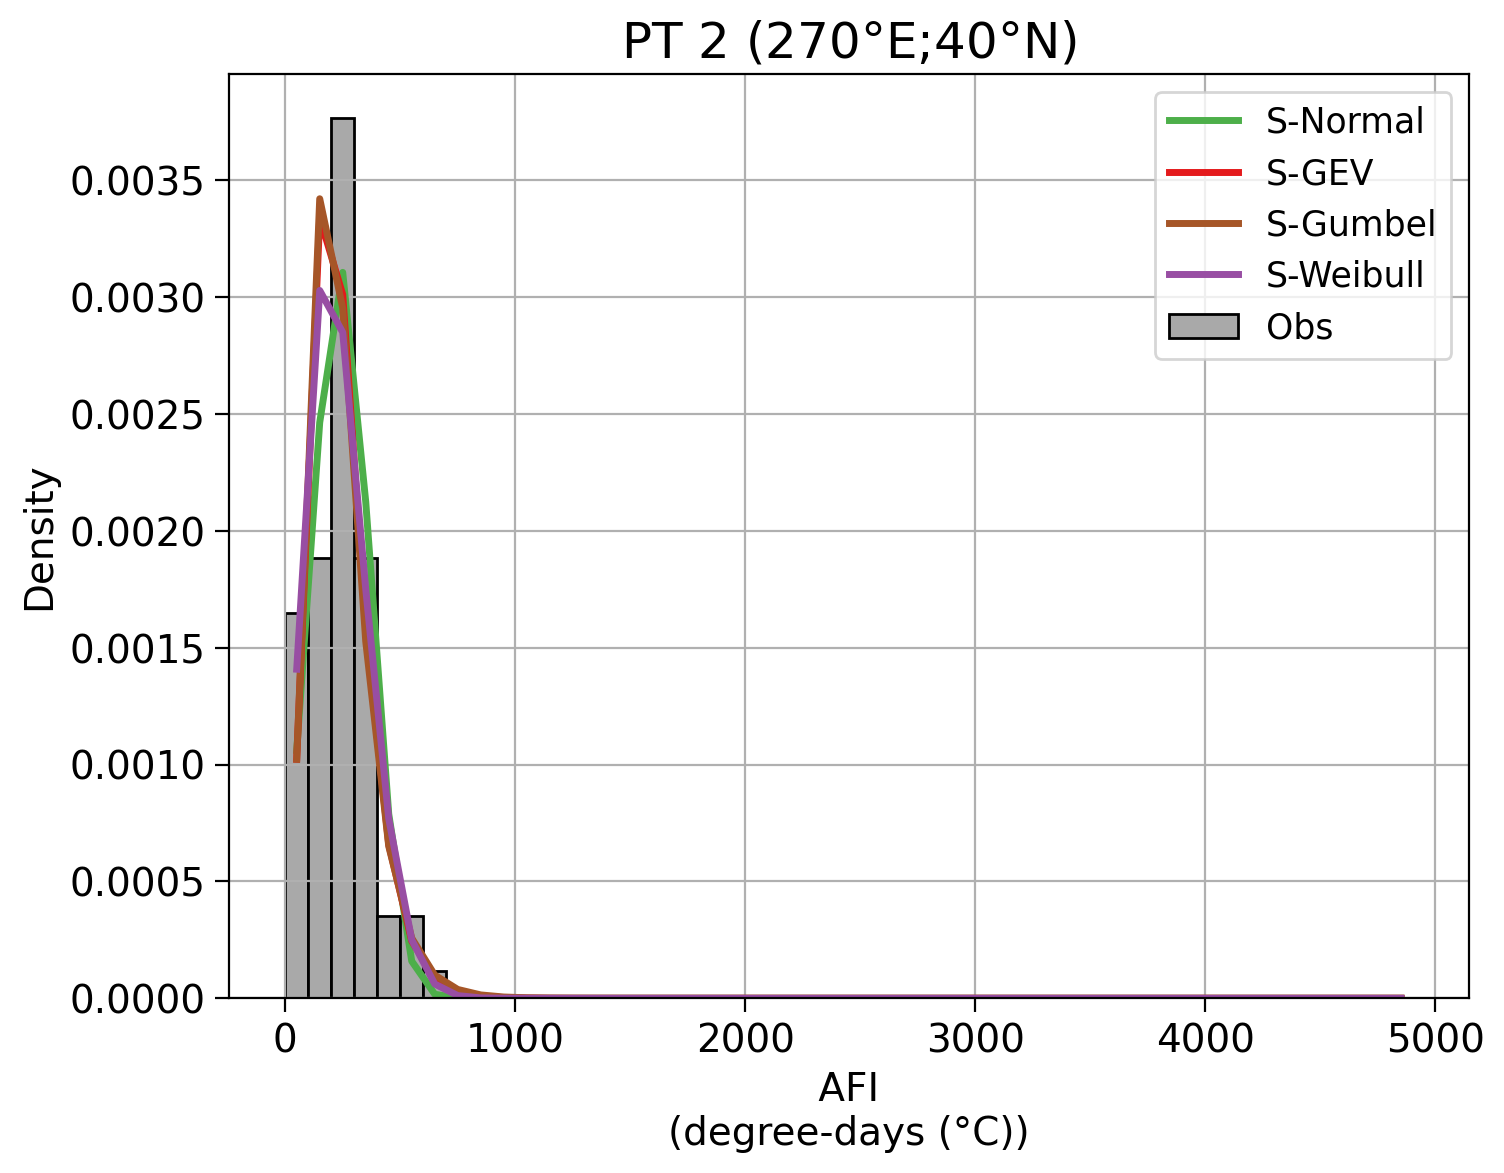

In [177]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5


fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 3

In [178]:
ij=2
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI               year     
 Min.   :  9.848   Min.   :1941  
 1st Qu.: 31.889   1st Qu.:1962  
 Median : 55.453   Median :1983  
 Mean   : 71.513   Mean   :1983  
 3rd Qu.: 97.831   3rd Qu.:2004  
 Max.   :283.095   Max.   :2025  



#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  438.497 


 Estimated parameters:
  location      scale      shape 
42.5460823 29.7197133  0.3356129 

 Standard Error Estimates:
 location     scale     shape 
3.8755851 3.3606165 0.1233866 

 Estimated parameter covariance matrix.
           location      scale       shape
location 15.0201599  9.0387744 -0.19188761
scale     9.0387744 11.2937434 -0.07117730
shape    -0.1918876 -0.0711773  0.01522426

 AIC = 882.994 

 BIC = 890.3219 


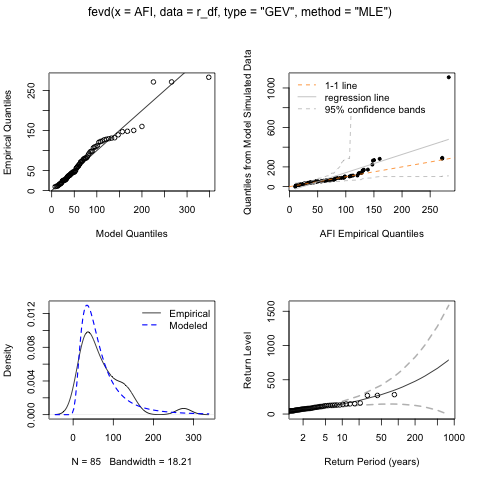

In [179]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  443.914 


 Estimated parameters:
location    scale 
48.50775 35.96556 

 Standard Error Estimates:
location    scale 
4.074094 3.270365 

 Estimated parameter covariance matrix.
          location     scale
location 16.598243  3.848885
scale     3.848885 10.695290

 AIC = 891.828 

 BIC = 896.7133 


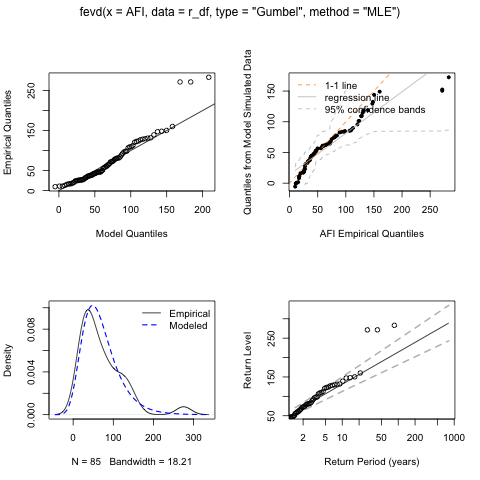

In [180]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [181]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb



Text(0.5, 1.0, 'PT 3 (264.25$\\degree$E; 37$\\degree$N)')

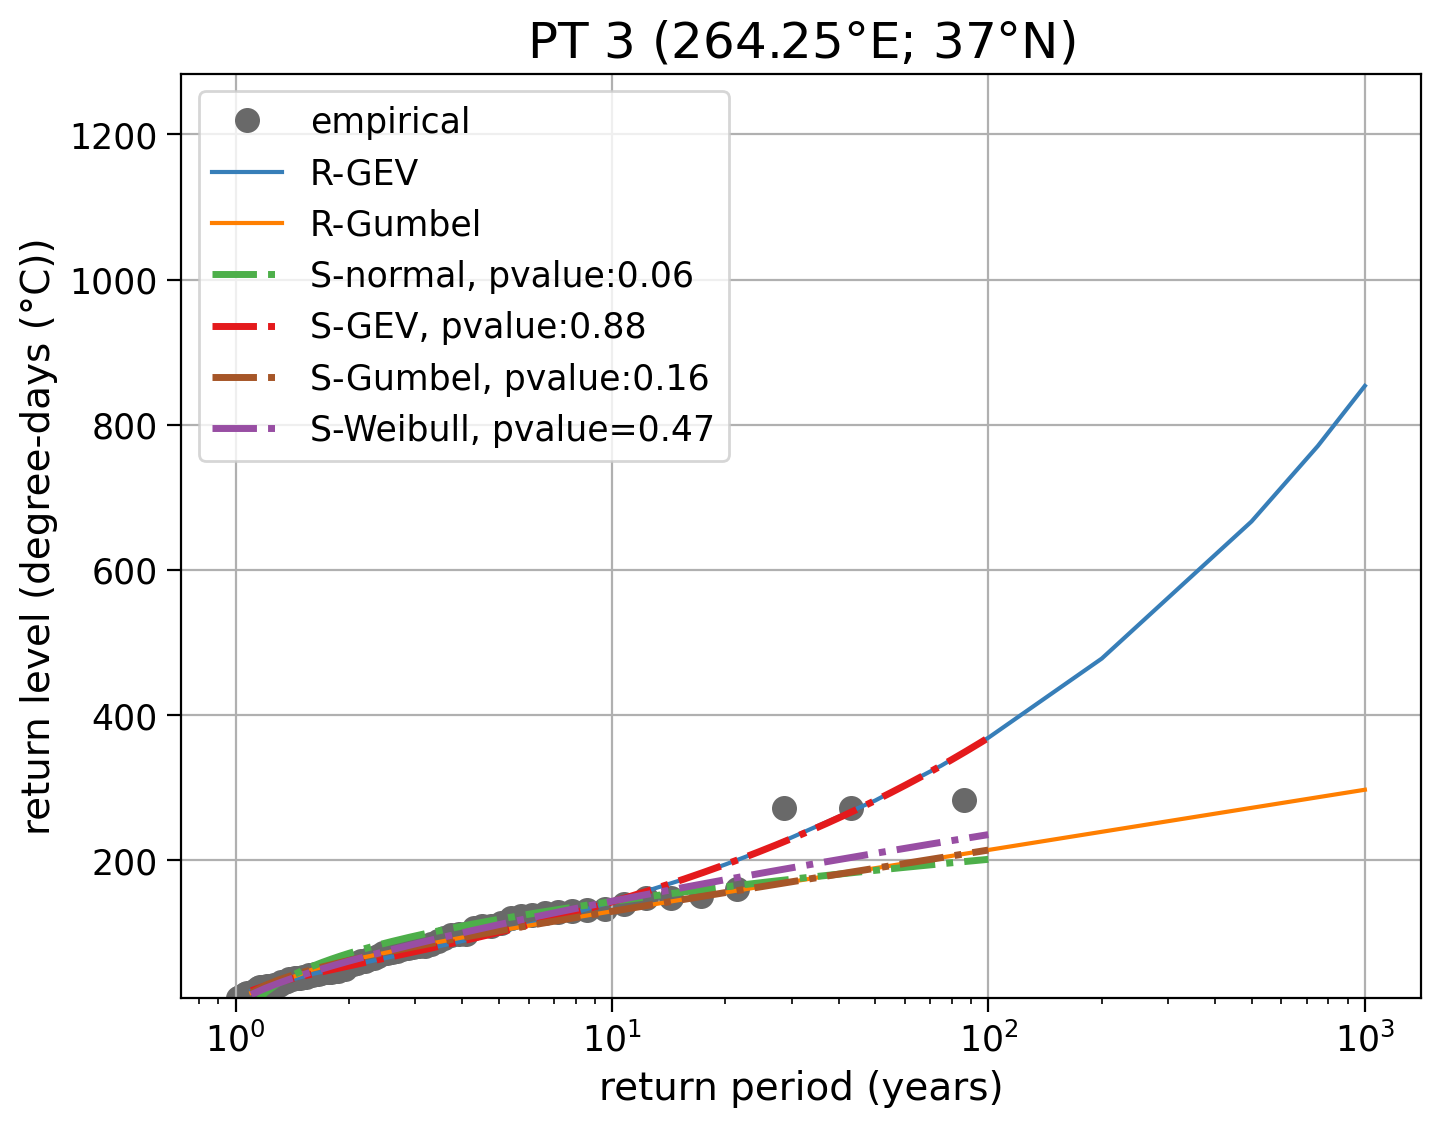

In [182]:
fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 3 (264.25$\\degree$E;37$\\degree$N)')

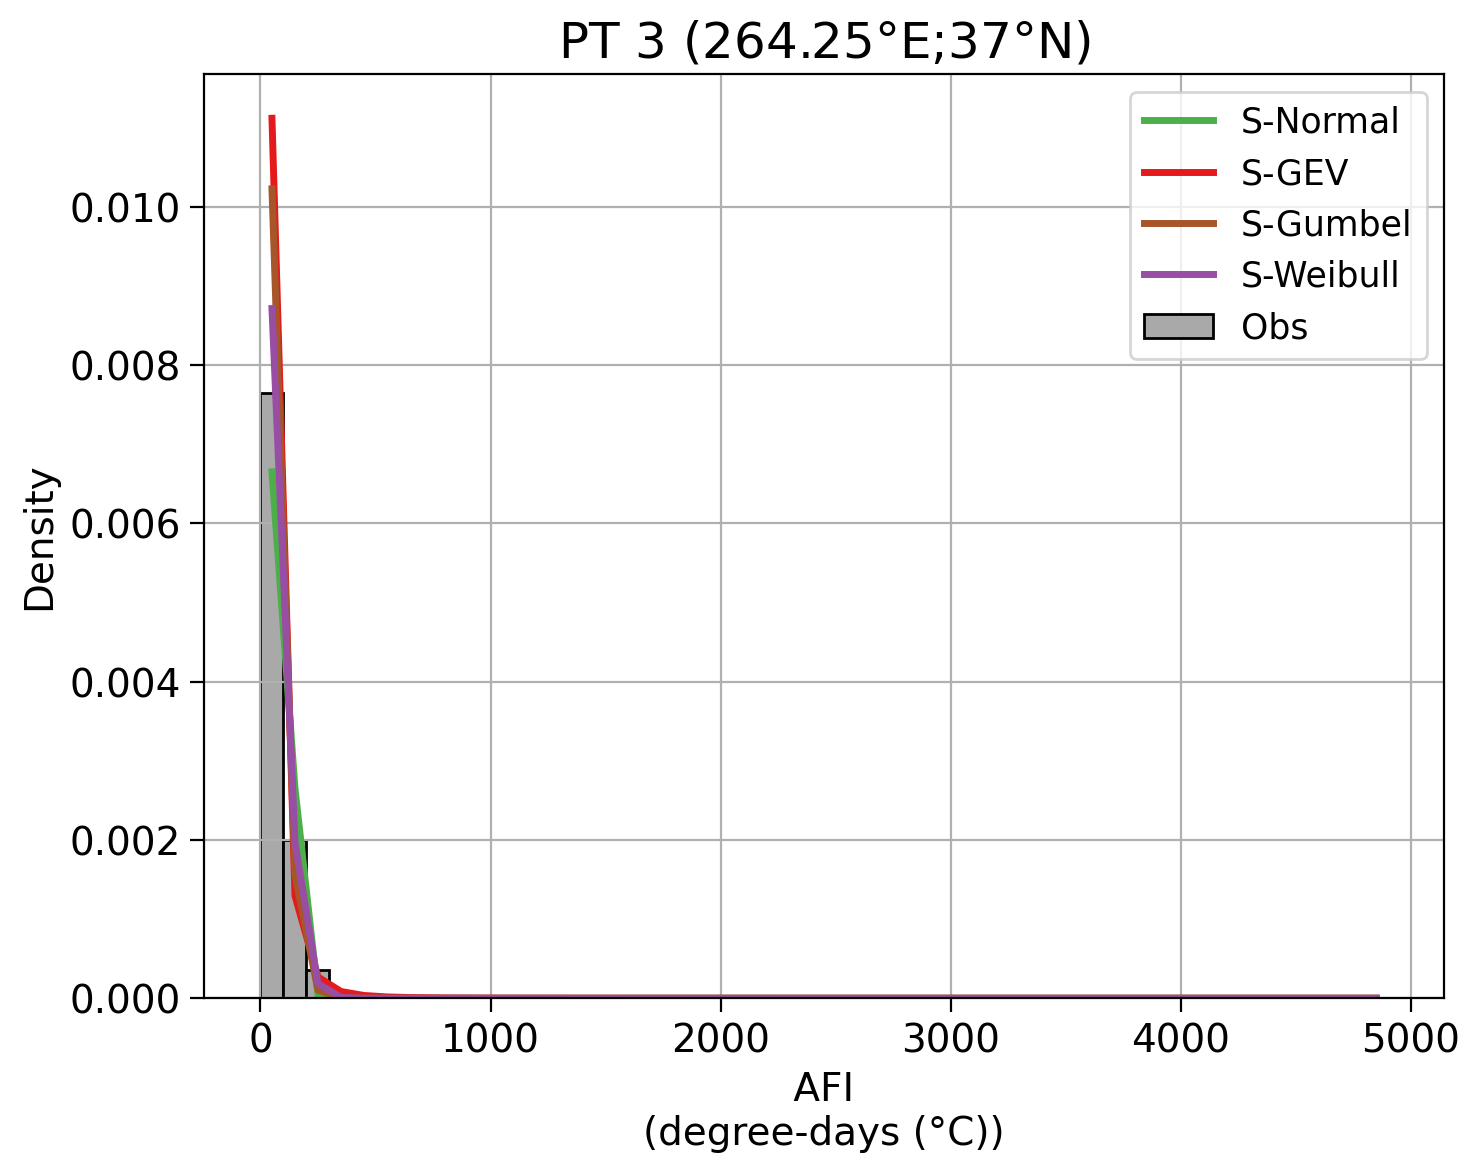

In [183]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 4

In [184]:
ij=3
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI                year     
 Min.   :  0.0354   Min.   :1941  
 1st Qu.: 28.0349   1st Qu.:1962  
 Median : 62.2576   Median :1983  
 Mean   : 89.1917   Mean   :1983  
 3rd Qu.:118.2241   3rd Qu.:2004  
 Max.   :451.6249   Max.   :2025  



#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  468.4398 


 Estimated parameters:
 location     scale     shape 
40.966145 38.410100  0.514874 

 Standard Error Estimates:
 location     scale     shape 
5.0174534 4.8365753 0.1332367 

 Estimated parameter covariance matrix.
          location       scale       shape
location 25.174839 18.59289763 -0.24170595
scale    18.592898 23.39246108 -0.03278634
shape    -0.241706 -0.03278634  0.01775202

 AIC = 942.8795 

 BIC = 950.2075 


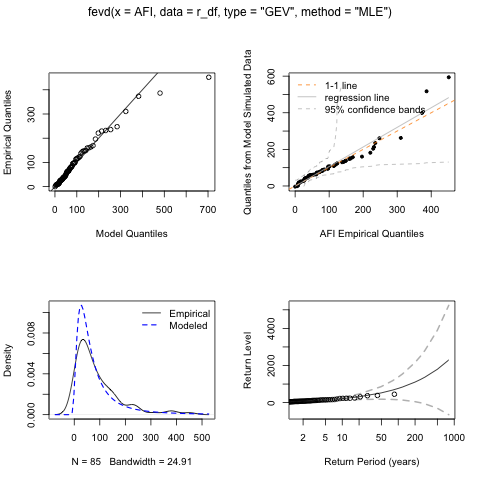

In [185]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R plot(fitGEV)
%R -o locGEV,scaleGEV,shapeGEV

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  480.1368 


 Estimated parameters:
location    scale 
53.39889 53.50199 

 Standard Error Estimates:
location    scale 
6.033675 4.985478 

 Estimated parameter covariance matrix.
          location     scale
location 36.405236  8.233597
scale     8.233597 24.854993

 AIC = 964.2735 

 BIC = 969.1588 


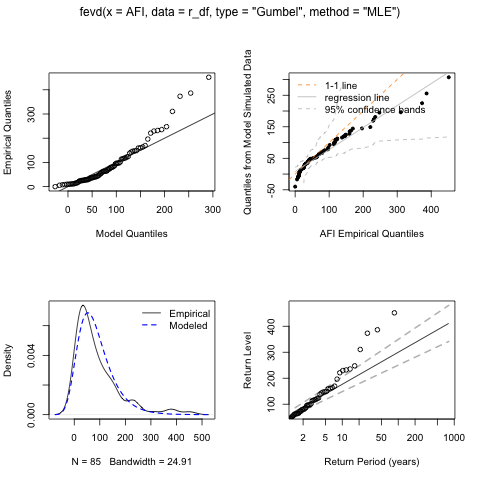

In [186]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [187]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGumb



Text(0.5, 1.0, 'PT 4 (241$\\degree$E; 46.25$\\degree$N)')

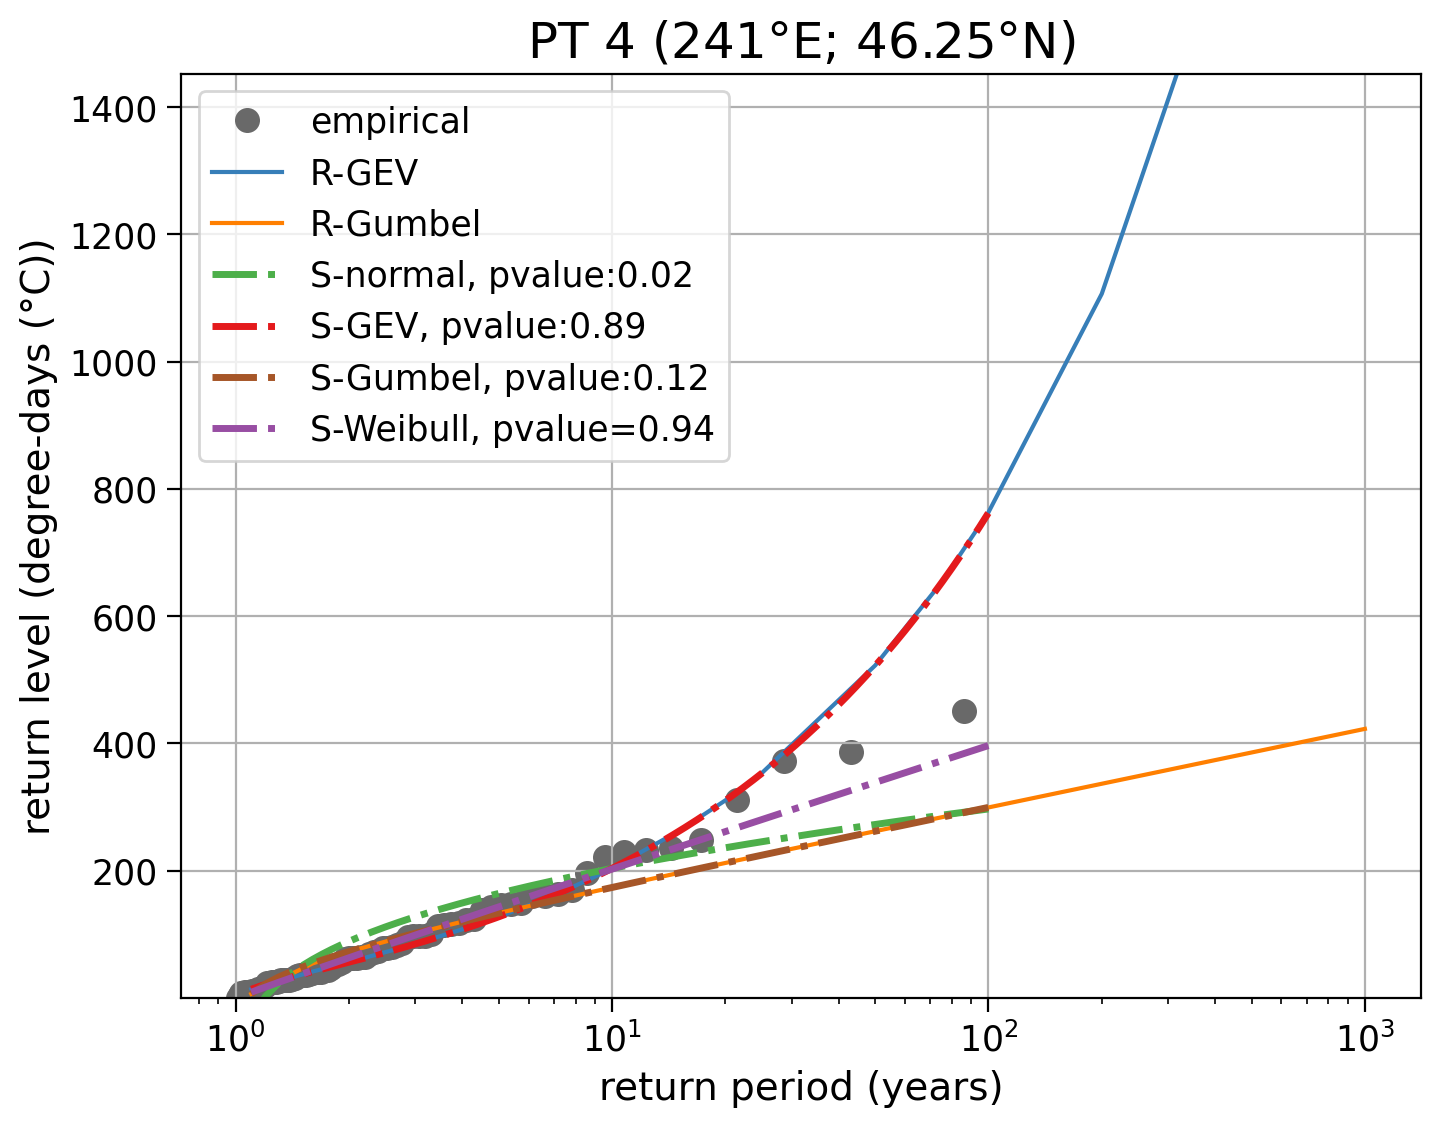

In [188]:
fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 4 (241$\\degree$E;46.25$\\degree$N)')

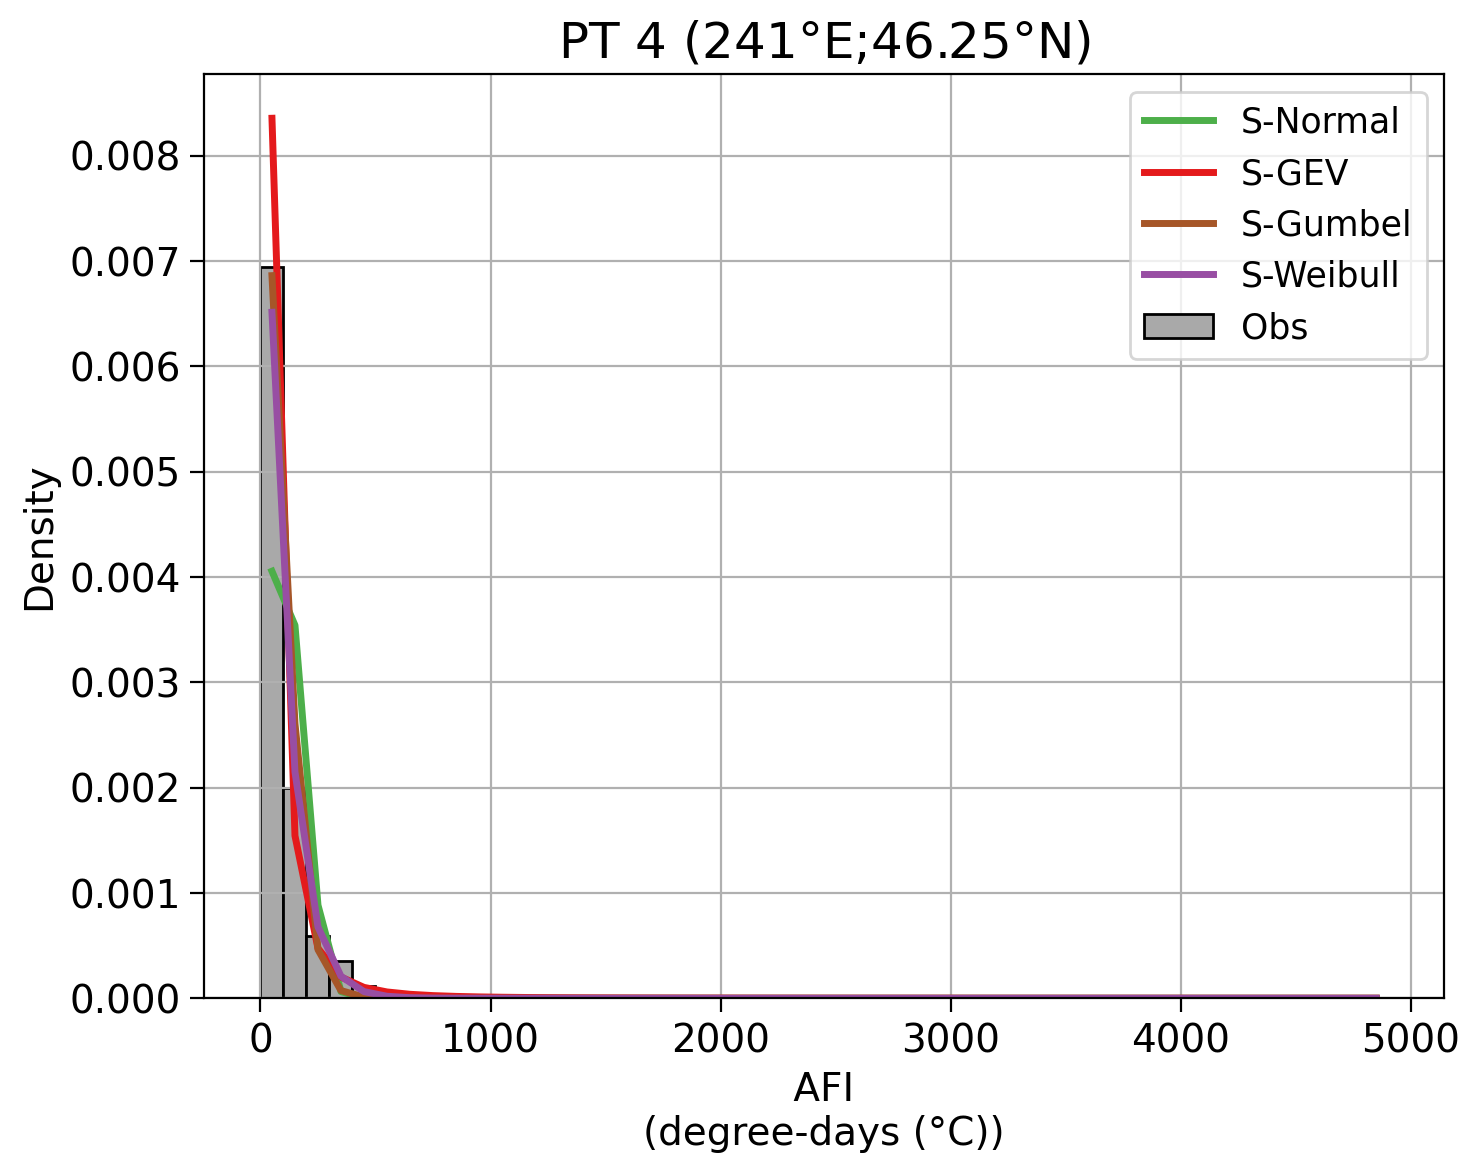

In [189]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 5

In [190]:
ij=4
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI            year     
 Min.   :3196   Min.   :1941  
 1st Qu.:4503   1st Qu.:1962  
 Median :4826   Median :1983  
 Mean   :4752   Mean   :1983  
 3rd Qu.:5077   3rd Qu.:2004  
 Max.   :5862   Max.   :2025  



In [191]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R -o locGEV,scaleGEV,shapeGEV

In addition: There were 14 warnings (use warnings() to see them)


#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  1e+10 


 Estimated parameters:
    location        scale        shape 
4526.0780809    5.9714704   -0.1221128 

 AIC = 2e+10 

 BIC = 2e+10 


#################
GEV + First Guess
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE", initial = initial_vals)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  648.9997 


 Estimated parameters:
    location        scale        shape 
4699.4457351  518.0898471   -0.4177066 

 Standard Error Estimates:
   location       scale       shape 
59.81006751 37.48927155  0.04747902 

 Estimated parameter covariance matrix.
            location       scale        shape
location 3577.244175  -92.633816 -1.430163031
scale     -92.633816 1405.445481 -1.183351765
shape      -1.430163   -1.183352  0.002254257

 AIC = 1303.999 

 BIC = 1311.327 


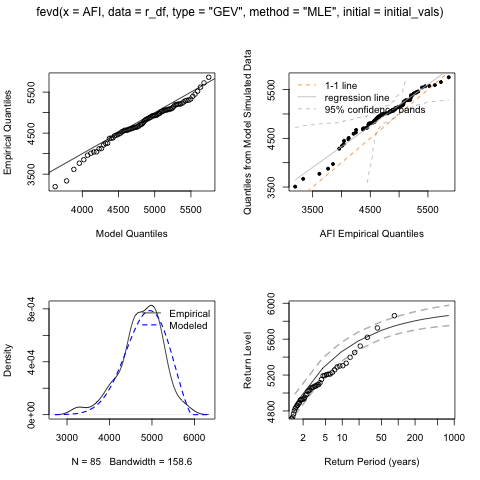

In [192]:
%R initial_vals <- list(location = mean(r_df[['AFI']]), scale = sd(r_df[['AFI']]), shape = 0.1)
%R fitGEV_FG <- fevd(AFI, data = r_df,type='GEV',method='MLE', initial = initial_vals)
%R fitGumb_FG <- fevd(AFI, data = r_df,type='Gumbel',method='MLE', initial = initial_vals) # Gumbel shape=0
print('#################')
print('GEV + First Guess')
print('#################')
%R pp <- summary(fitGEV_FG)
%R locGEV_FG <- pp[['par']][['location']]
%R scaleGEV_FG <- pp[['par']][['scale']]
%R shapeGEV_FG <- pp[['par']][['shape']]
%R plot(fitGEV_FG)
%R -o locGEV_FG,scaleGEV_FG,shapeGEV_FG

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  663.9766 


 Estimated parameters:
 location     scale 
4496.9368  576.3129 

 Standard Error Estimates:
location    scale 
66.46530 42.56936 

 Estimated parameter covariance matrix.
         location    scale
location 4417.636 1002.986
scale    1002.986 1812.150

 AIC = 1331.953 

 BIC = 1336.838 


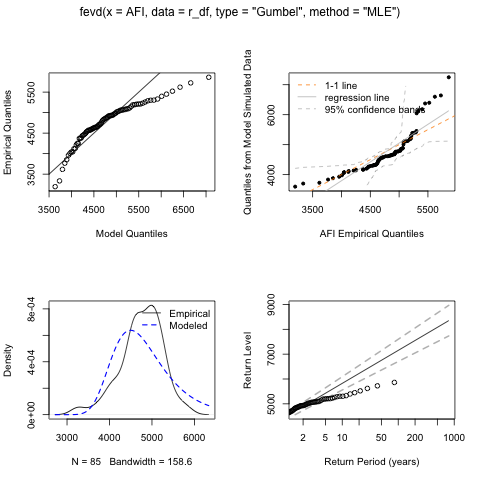

In [193]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [194]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGEV_FG<-return.level(fitGEV_FG, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGEV_FG,rlGumb


Text(0.5, 1.0, 'PT 5 (205$\\degree$E; 68.75$\\degree$N)')

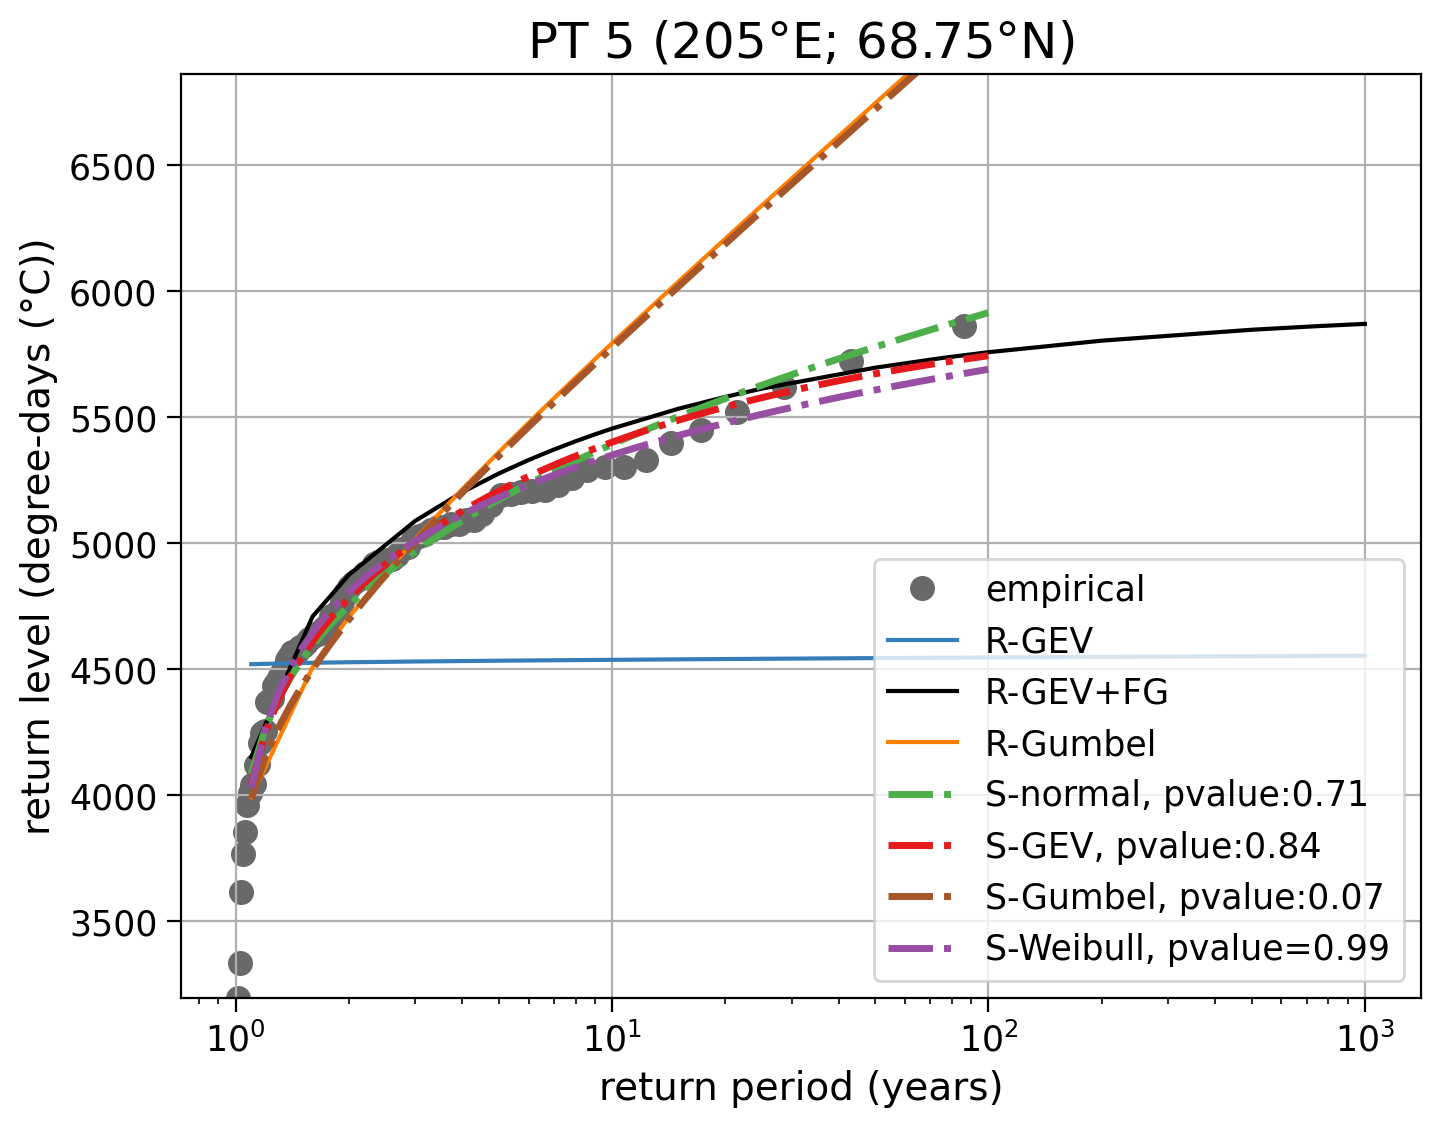

In [195]:
fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGEV_FG,c='k',label='R-GEV+FG')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 5 (205$\\degree$E;68.75$\\degree$N)')

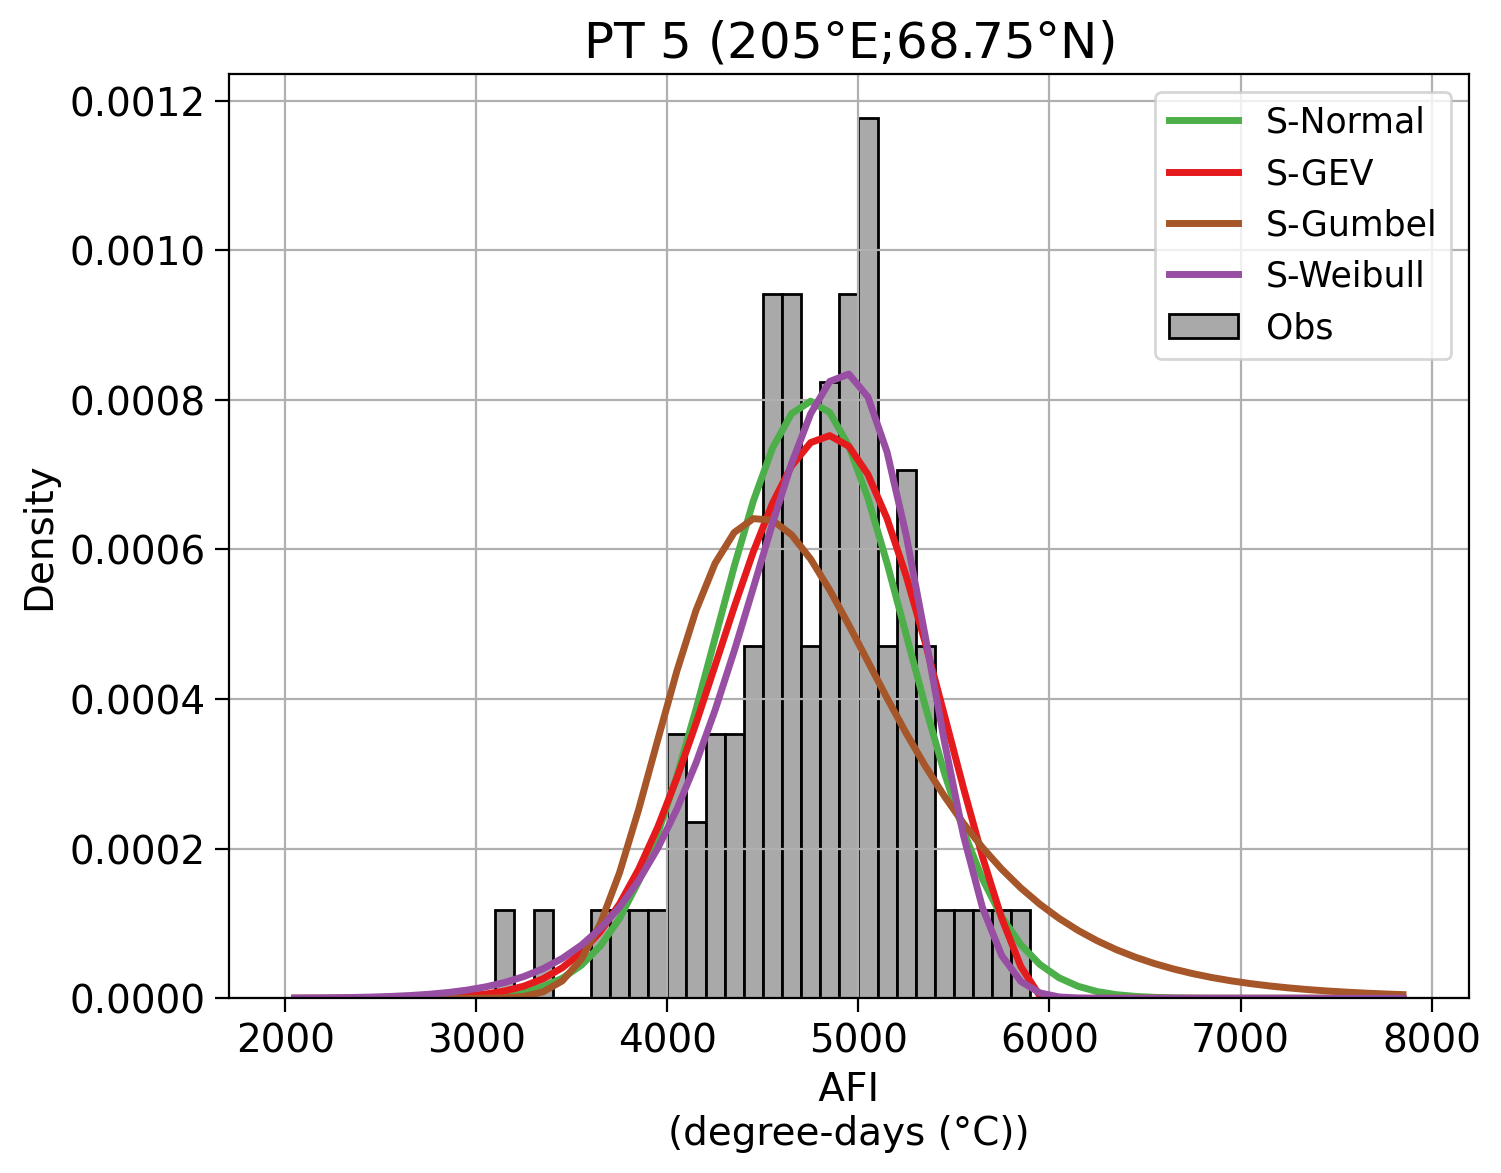

In [196]:
####
##### PDF Plot
#####

bins = np.arange(2000,8000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 6

In [197]:
ij=5
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI              year     
 Min.   : 395.5   Min.   :1941  
 1st Qu.:1360.0   1st Qu.:1962  
 Median :1641.0   Median :1983  
 Mean   :1563.1   Mean   :1983  
 3rd Qu.:1853.2   3rd Qu.:2004  
 Max.   :2744.0   Max.   :2025  



In [198]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R -o locGEV,scaleGEV,shapeGEV

In addition: There were 14 warnings (use warnings() to see them)


#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  1e+10 


 Estimated parameters:
    location        scale        shape 
1359.3317782    5.8669310   -0.1980338 

 AIC = 2e+10 

 BIC = 2e+10 


#################
GEV + First Guess
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE", initial = initial_vals)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  642.067 


 Estimated parameters:
   location       scale       shape 
1499.629896  468.907075   -0.343602 

 Standard Error Estimates:
   location       scale       shape 
54.34593451 34.14926536  0.04260265 

 Estimated parameter covariance matrix.
            location        scale        shape
location 2953.480598  133.3718381 -1.114635745
scale     133.371838 1166.1723248 -0.965699234
shape      -1.114636   -0.9656992  0.001814986

 AIC = 1290.134 

 BIC = 1297.462 


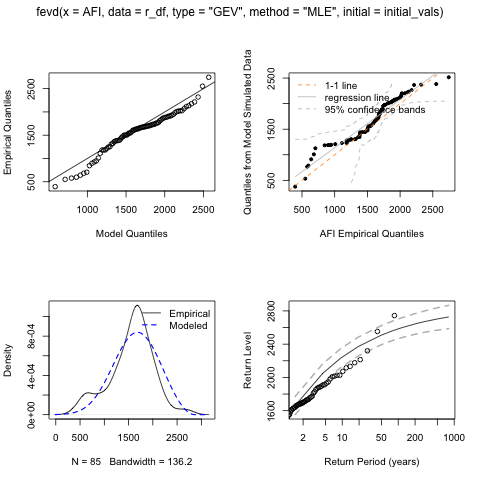

In [199]:
%R initial_vals <- list(location = mean(r_df[['AFI']]), scale = sd(r_df[['AFI']]), shape = 0.1)
%R fitGEV_FG <- fevd(AFI, data = r_df,type='GEV',method='MLE', initial = initial_vals)
%R fitGumb_FG <- fevd(AFI, data = r_df,type='Gumbel',method='MLE', initial = initial_vals) # Gumbel shape=0
print('#################')
print('GEV + First Guess')
print('#################')
%R pp <- summary(fitGEV_FG)
%R locGEV_FG <- pp[['par']][['location']]
%R scaleGEV_FG <- pp[['par']][['scale']]
%R shapeGEV_FG <- pp[['par']][['shape']]
%R plot(fitGEV_FG)
%R -o locGEV_FG,scaleGEV_FG,shapeGEV_FG

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  651.7749 


 Estimated parameters:
 location     scale 
1334.6452  484.6678 

 Standard Error Estimates:
location    scale 
55.91608 36.96541 

 Estimated parameter covariance matrix.
          location     scale
location 3126.6079  738.2055
scale     738.2055 1366.4416

 AIC = 1307.55 

 BIC = 1312.435 


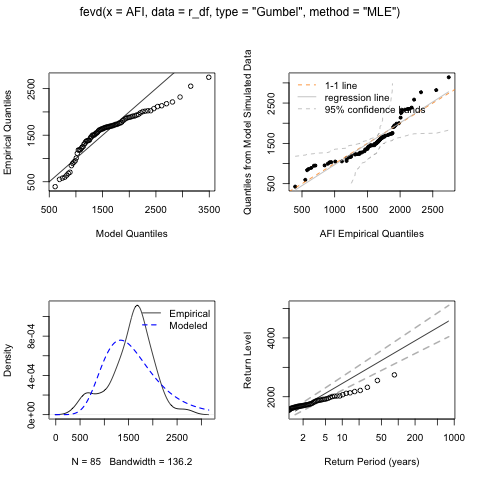

In [200]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [201]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGEV_FG<-return.level(fitGEV_FG, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGEV_FG,rlGumb


Text(0.5, 1.0, 'PT 6 (204$\\degree$E; 60$\\degree$N)')

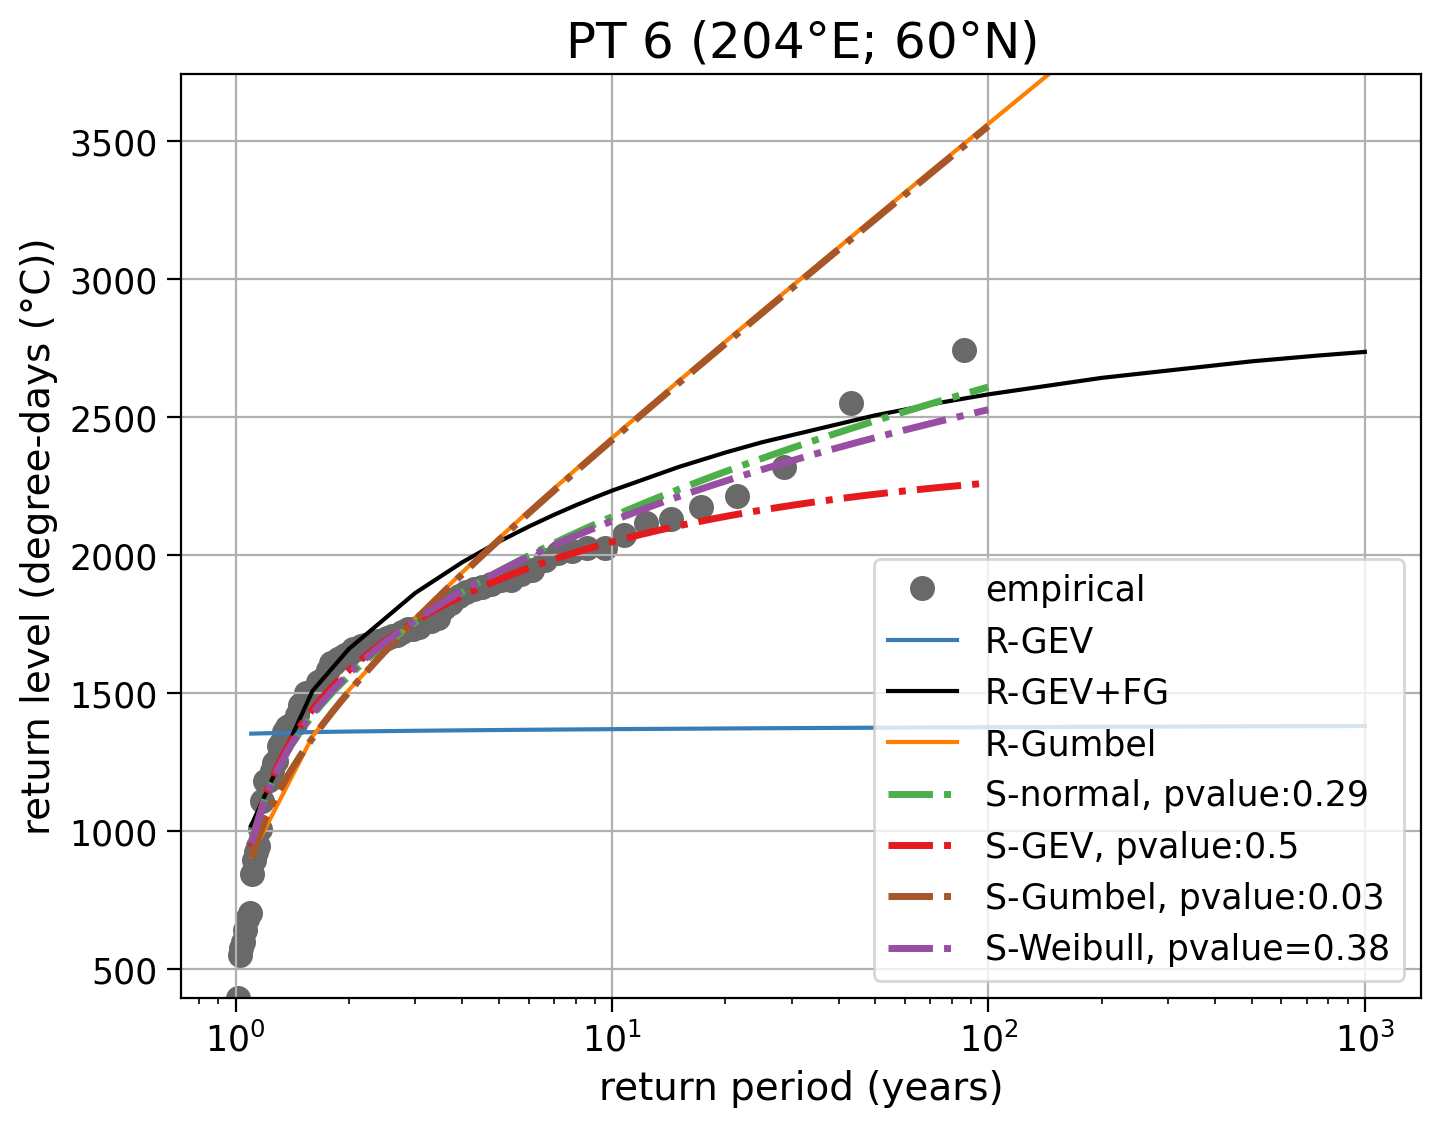

In [202]:
fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGEV_FG,c='k',label='R-GEV+FG')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 6 (204$\\degree$E;60$\\degree$N)')

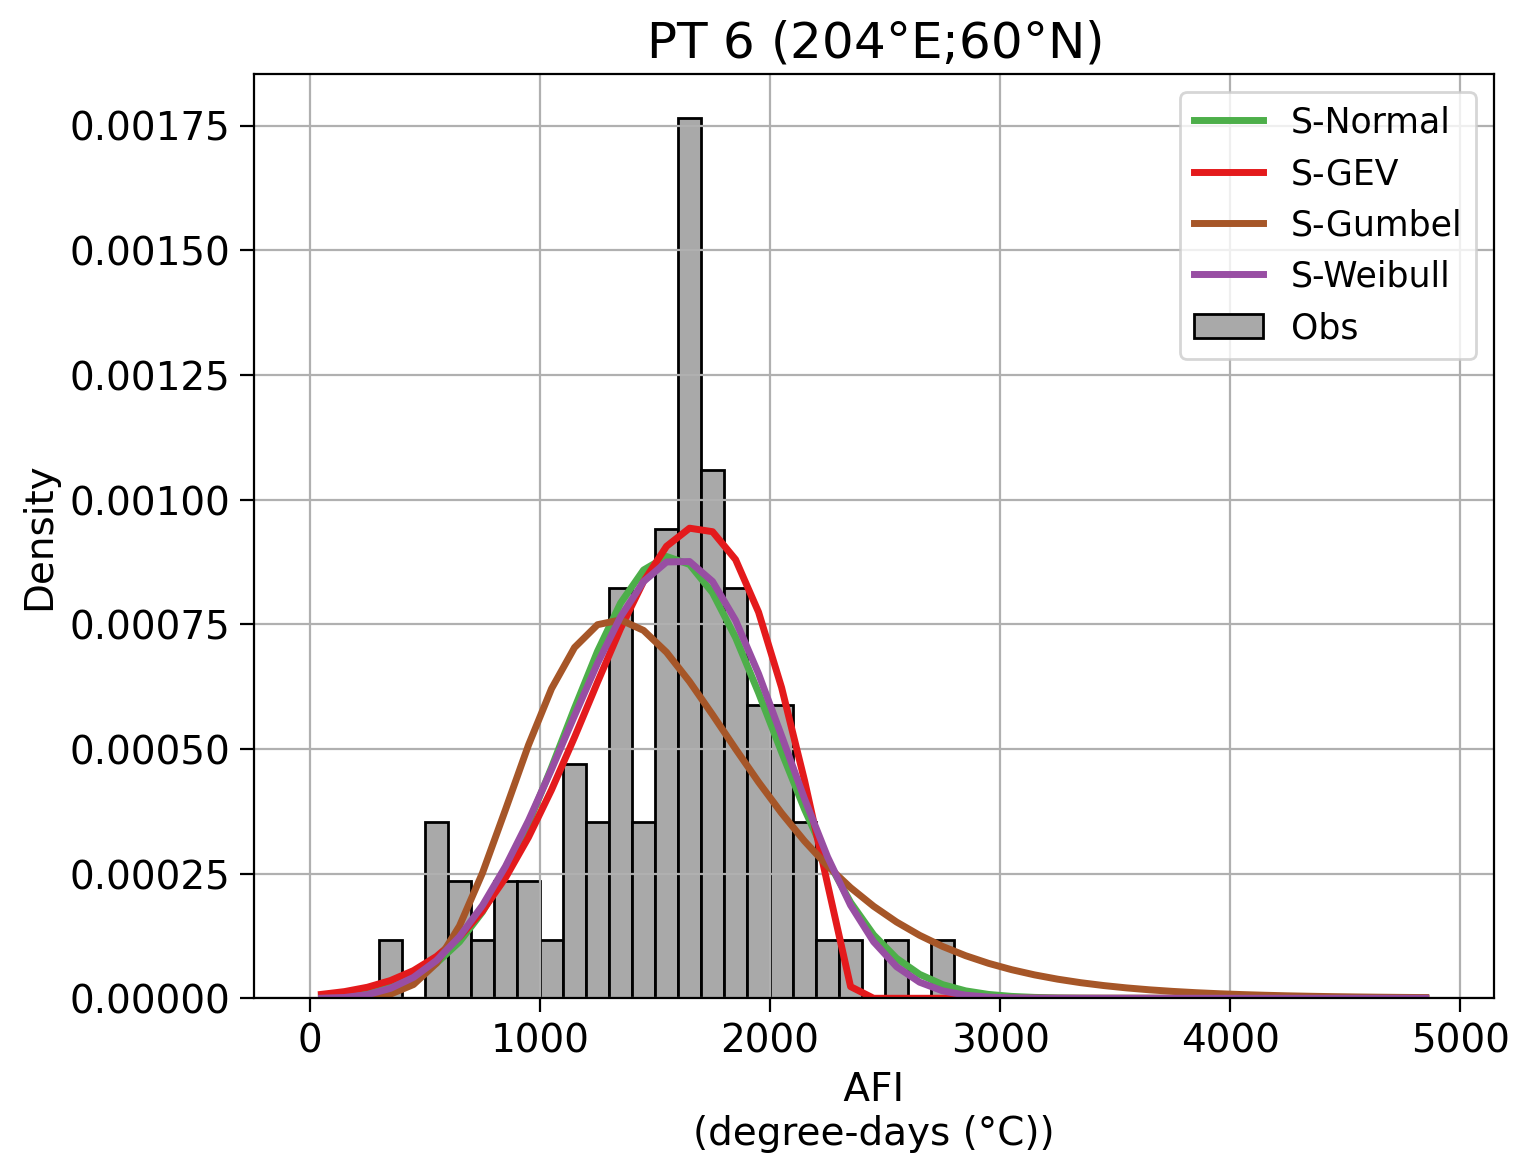

In [203]:
####
##### PDF Plot
#####

bins = np.arange(0,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')

# Pt 7 
# Point in Maine

In [204]:

ij = 6
ilon=ptlon[ij]
ilat=ptlat[ij]
afi=ds['AFI'].sel(lon=ilon,lat=ilat).load()

# Extract AFI values
afi_values = afi.values
# Remove zeros if any (as in Bilotta et al.)
nonzero_afis = afi_values[afi_values > 0]

df = afi.where(afi>0).to_dataframe()
df=df.drop(columns=['lat','lon'])
df['year'] = df.index

# Convert pandas DataFrame to R data.frame
with (ro.default_converter + pandas2ri.converter).context():
  r_df = ro.conversion.get_conversion().py2rpy(df)

# You can now work with 'r_df' in R
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df

      AFI              year     
 Min.   : 599.2   Min.   :1941  
 1st Qu.: 947.1   1st Qu.:1962  
 Median :1092.0   Median :1983  
 Mean   :1065.8   Mean   :1983  
 3rd Qu.:1203.5   3rd Qu.:2004  
 Max.   :1434.9   Max.   :2025  



In [205]:
%R fitGEV <- fevd(AFI, data = r_df,type='GEV',method='MLE')
%R fitGumb <- fevd(AFI, data = r_df,type='Gumbel',method='MLE') # Gumbel shape=0
print('#################')
print('GEV')
print('#################')
%R pp <- summary(fitGEV)
%R locGEV <- pp[['par']][['location']]
%R scaleGEV <- pp[['par']][['scale']]
%R shapeGEV <- pp[['par']][['shape']]
%R -o locGEV,scaleGEV,shapeGEV

In addition: There were 14 warnings (use warnings() to see them)


#################
GEV
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  1e+10 


 Estimated parameters:
  location      scale      shape 
981.720315   4.996400  -2.998256 

 AIC = 2e+10 

 BIC = 2e+10 


#################
GEV + First Guess
#################

fevd(x = AFI, data = r_df, type = "GEV", method = "MLE", initial = initial_vals)

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  561.3293 


 Estimated parameters:
   location       scale       shape 
1014.658843  199.475508   -0.447472 

 Standard Error Estimates:
   location       scale       shape 
23.14288343 17.11766845  0.05365914 

 Estimated parameter covariance matrix.
             location        scale        shape
location  535.5930536 -101.9122745 -0.419477429
scale    -101.9122745  293.0145733 -0.633902521
shape      -0.4194774   -0.6339025  0.002879303

 AIC = 1128.659 

 BIC = 1135.987 


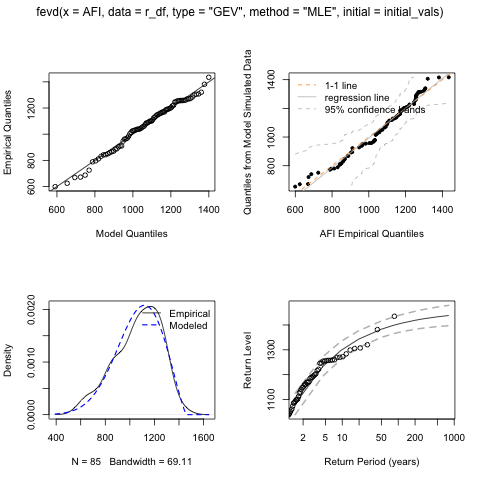

In [206]:
%R initial_vals <- list(location = mean(r_df[['AFI']]), scale = sd(r_df[['AFI']]), shape = 0.1)
%R fitGEV_FG <- fevd(AFI, data = r_df,type='GEV',method='MLE', initial = initial_vals)
print('#################')
print('GEV + First Guess')
print('#################')
%R pp <- summary(fitGEV_FG)
%R locGEV_FG <- pp[['par']][['location']]
%R scaleGEV_FG <- pp[['par']][['scale']]
%R shapeGEV_FG <- pp[['par']][['shape']]
%R plot(fitGEV_FG)
%R -o locGEV_FG,scaleGEV_FG,shapeGEV_FG

#################
Gumbel
#################

fevd(x = AFI, data = r_df, type = "Gumbel", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  576.1713 


 Estimated parameters:
location    scale 
968.6827 198.2465 

 Standard Error Estimates:
location    scale 
22.86592 15.38836 

 Estimated parameter covariance matrix.
         location    scale
location 522.8501 119.3670
scale    119.3670 236.8017

 AIC = 1156.343 

 BIC = 1161.228 


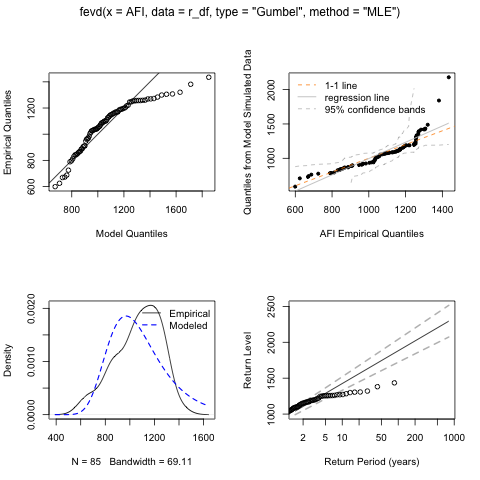

In [207]:
print('#################')
print('Gumbel')
print('#################')
%R pp <- summary(fitGumb)
%R locGumb <- pp[['par']][['location']]
%R scaleGumb <- pp[['par']][['scale']]
%R plot(fitGumb)
%R -o locGumb,scaleGumb,pp

In [208]:
%R return_periods <- c(1.1,1.6,2,3,4,5,6,7,8,9,10,15, 20,25, 50,75, 100, 200,500,750,1000)
%R rlGEV<-return.level(fitGEV, return.period = return_periods, make.plot=TRUE)
%R rlGEV_FG<-return.level(fitGEV_FG, return.period = return_periods, make.plot=TRUE)
%R rlGumb<-return.level(fitGumb, return.period = return_periods, make.plot=TRUE)
%R -o rlGEV,rlGEV_FG,rlGumb

Text(0.5, 1.0, 'PT 7 (289$\\degree$E; 45$\\degree$N)')

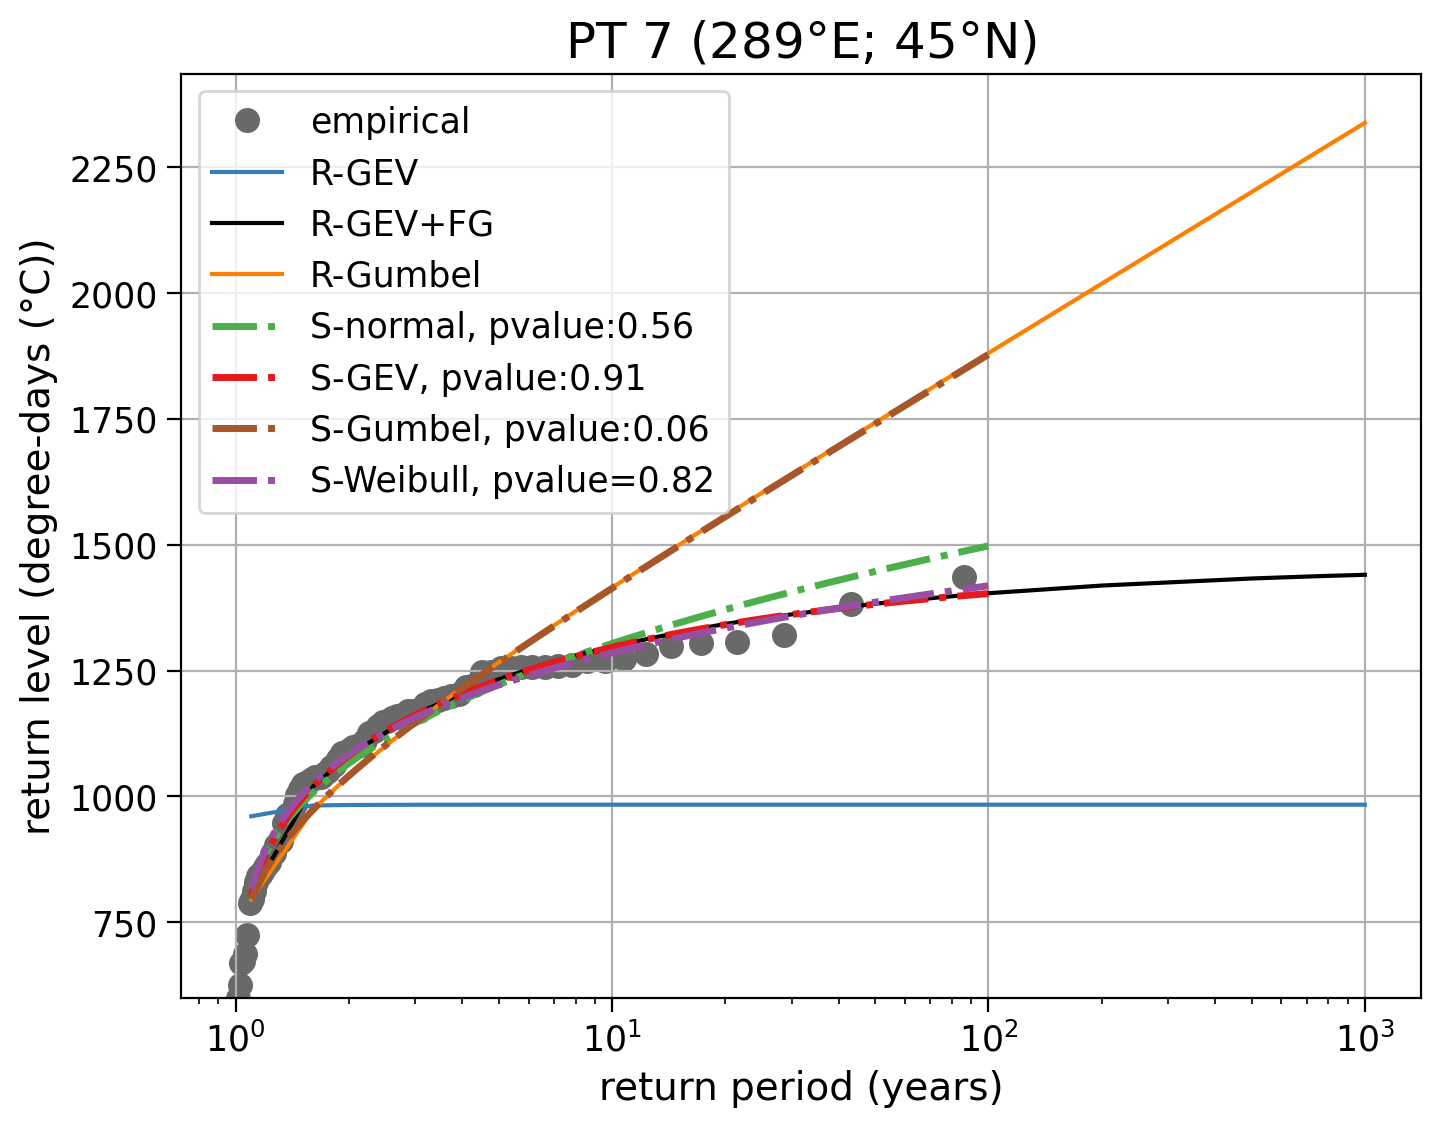

In [209]:
fig, ax = plt.subplots(nrows=1,ncols=1)
# plot empirical 
_ = empirical_return_level(nonzero_afis).plot(ax=ax, marker="o",linestyle='None',markersize=8, color='dimgrey',label="empirical",zorder=1)

# plot R-distribution 
ax.plot(c,rlGEV,c=CB_color[0],label='R-GEV')
ax.plot(c,rlGEV_FG,c='k',label='R-GEV+FG')
ax.plot(c,rlGumb,c=CB_color[1],label='R-Gumbel')

# calculate and plot the normal return levels
pv_n=np.round(stats.kstest(nonzero_afis,stats.norm.cdf, \
     args=(nonzero_afis.mean(),nonzero_afis.std()),N=ksN)[1],2)
ax.plot(years,stats.norm.ppf(1 - 1 / years, loc=nonzero_afis.mean(), scale=nonzero_afis.std())\
     ,c=CB_color[2],lw=2.5,ls='-.',label=f"S-normal, pvalue:{pv_n}")

# calculate and plot the GEV distribution, optimized
pgev = gev.fit(nonzero_afis, method="MLE", loc=nonzero_afis.mean(), scale=nonzero_afis.std(), )
pv_g= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgev, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years, *pgev),c=CB_color[3],lw=2.5,ls='-.',label=f"S-GEV, pvalue:{pv_g}")

# calculate and plot the Gumbel distribution
pgum = gev.fit(nonzero_afis,fc=0,loc=nonzero_afis.mean(), scale=nonzero_afis.std() ,method="MLE") # fc=0 fixes the shape parameter at 0
pv_gu= np.round(stats.kstest(nonzero_afis, 'genextreme', args=pgum, N=ksN)[1],2)
ax.plot(years, gev.ppf(1 - 1 / years,*pgum),c=CB_color[4],lw=2.5,ls='-.',label=f"S-Gumbel, pvalue:{pv_gu}")

# Weibul distribution
params = stats.weibull_min.fit(nonzero_afis, floc=0, loc=nonzero_afis.mean(), scale=nonzero_afis.std()) # floc=0 fixes the location parameter at 0
c_est, loc_est, scale_est = params
pv_w = stats.kstest(nonzero_afis, stats.weibull_min.name, params,N=ksN)[1]
ax.plot(years, stats.weibull_min(c_est, loc_est, scale_est).ppf(1 - 1 / years),c=CB_color[5],lw=2.5,ls='-.',label=f"S-Weibull, pvalue={pv_w:0.2f}")


#ax.set_xlim(0,100)
# set x axis to log scale
ax.set_xscale("log")

ax.set_ylabel(f'return level ({units})',fontsize=14)
ax.set_xlabel('return period (years)',fontsize=14)

ax.grid()
# set y axis lim
ax.set_ylim(nonzero_afis.min(),nonzero_afis.max()+1000.)
# show legend
ax.legend()
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E; {ilat}$\degree$N)')

Text(0.5, 1.0, 'PT 7 (289$\\degree$E;45$\\degree$N)')

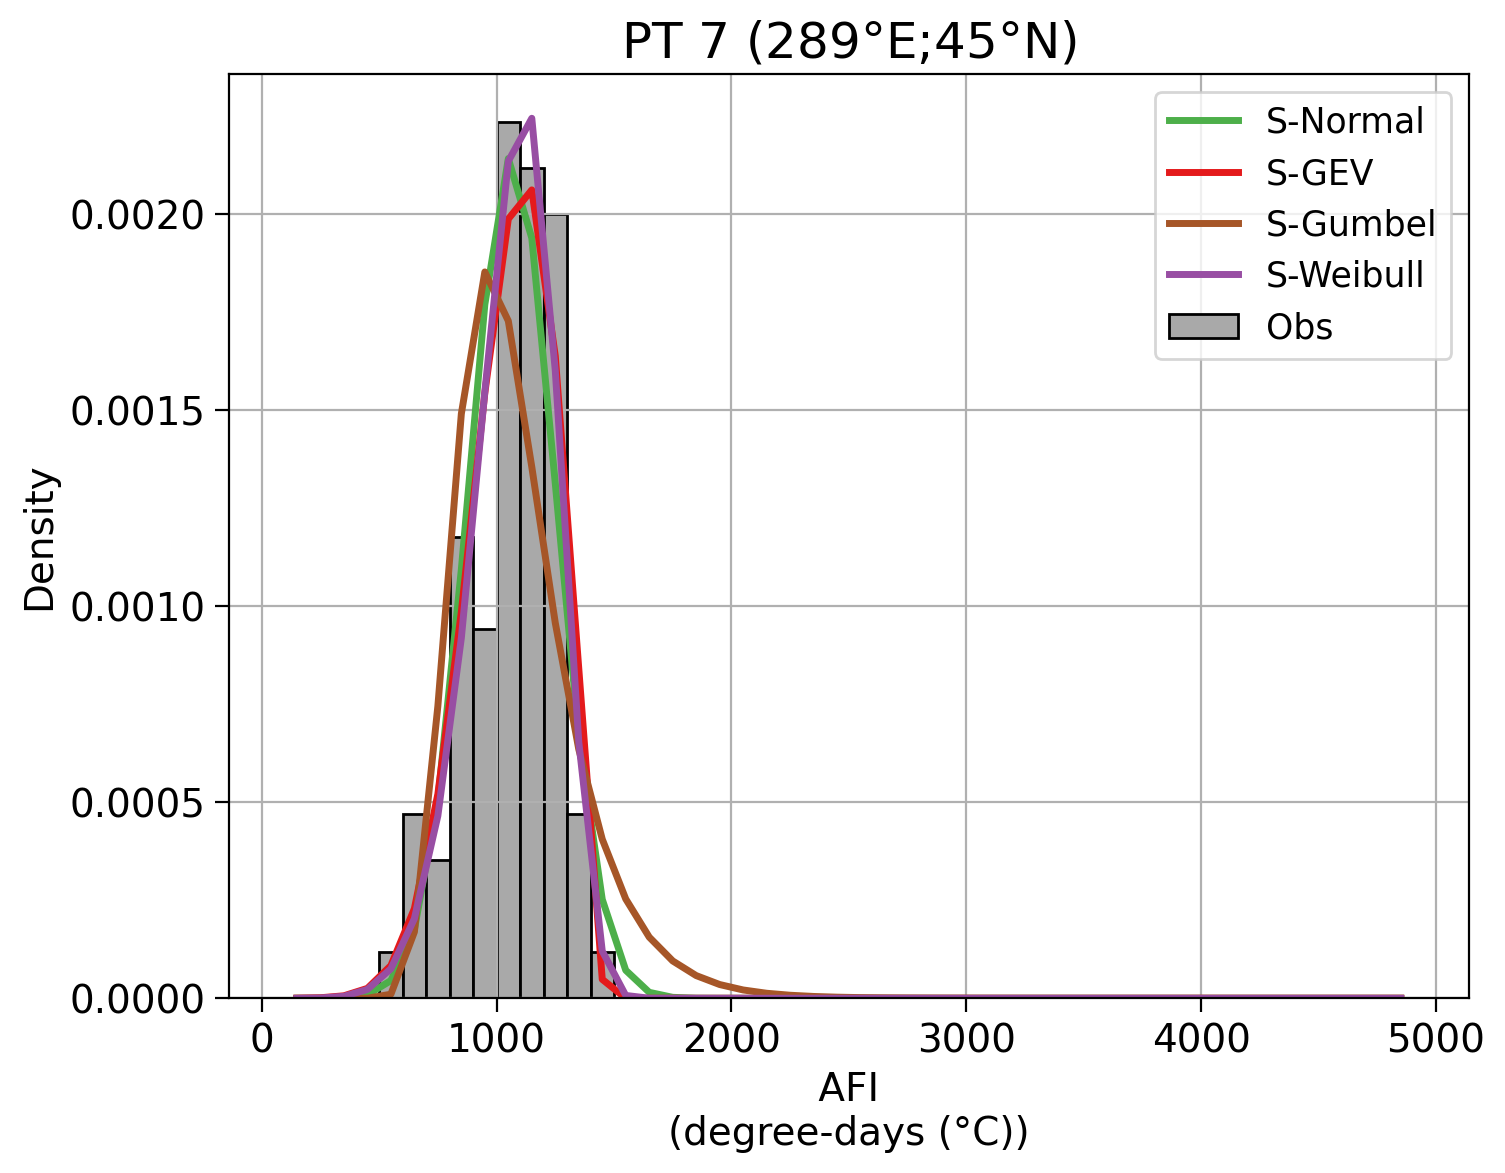

In [210]:
####
##### PDF Plot
#####

bins = np.arange(100,5000,100)
x100 = (bins[1:]+bins[:-1])*0.5
# create vector of years
years = np.arange(1.1, 100, 0.1)

fig, ax= plt.subplots(nrows=1,ncols=1,figsize=(8,6))
dh=histogram(afi.where(afi>0), bins=bins,density=True, block_size=None)
ax.bar((bins[1:]+bins[:-1])*0.5,dh.data,edgecolor='k',color='darkgrey',\
          width=np.diff(bins), label='Obs')

# normal distribution
ax.plot(x100,stats.norm.pdf(x100, loc=nonzero_afis.mean(), scale=nonzero_afis.std()),
    c=CB_color[2],lw=2.5,label="S-Normal")
 
# GEV distribution
ax.plot(x100, gev.pdf(x100, *pgev), c=CB_color[3], lw=2.5, label="S-GEV")
# Gumbl distribution
ax.plot(x100, gev.pdf(x100, *pgum), c=CB_color[4], lw=2.5, label="S-Gumbel")

# Weibul distribution
ax.plot(x100, stats.weibull_min(c_est, loc_est, scale_est).pdf(x100), c=CB_color[5], lw=2.5, label="S-Weibull")

# calculate and plot the Gumbl distribution
shape, loc, scale = gev.fit(nonzero_afis,0)
ax.legend()
ax.grid()
ax.set_xlabel(f" AFI \n({units})",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=14)
ax.set_title(f'PT {ij+1} ({ilon}$\degree$E;{ilat}$\degree$N)')